In [13]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import pandas as pd
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


In [2]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 1946


<IPython.core.display.Javascript object>


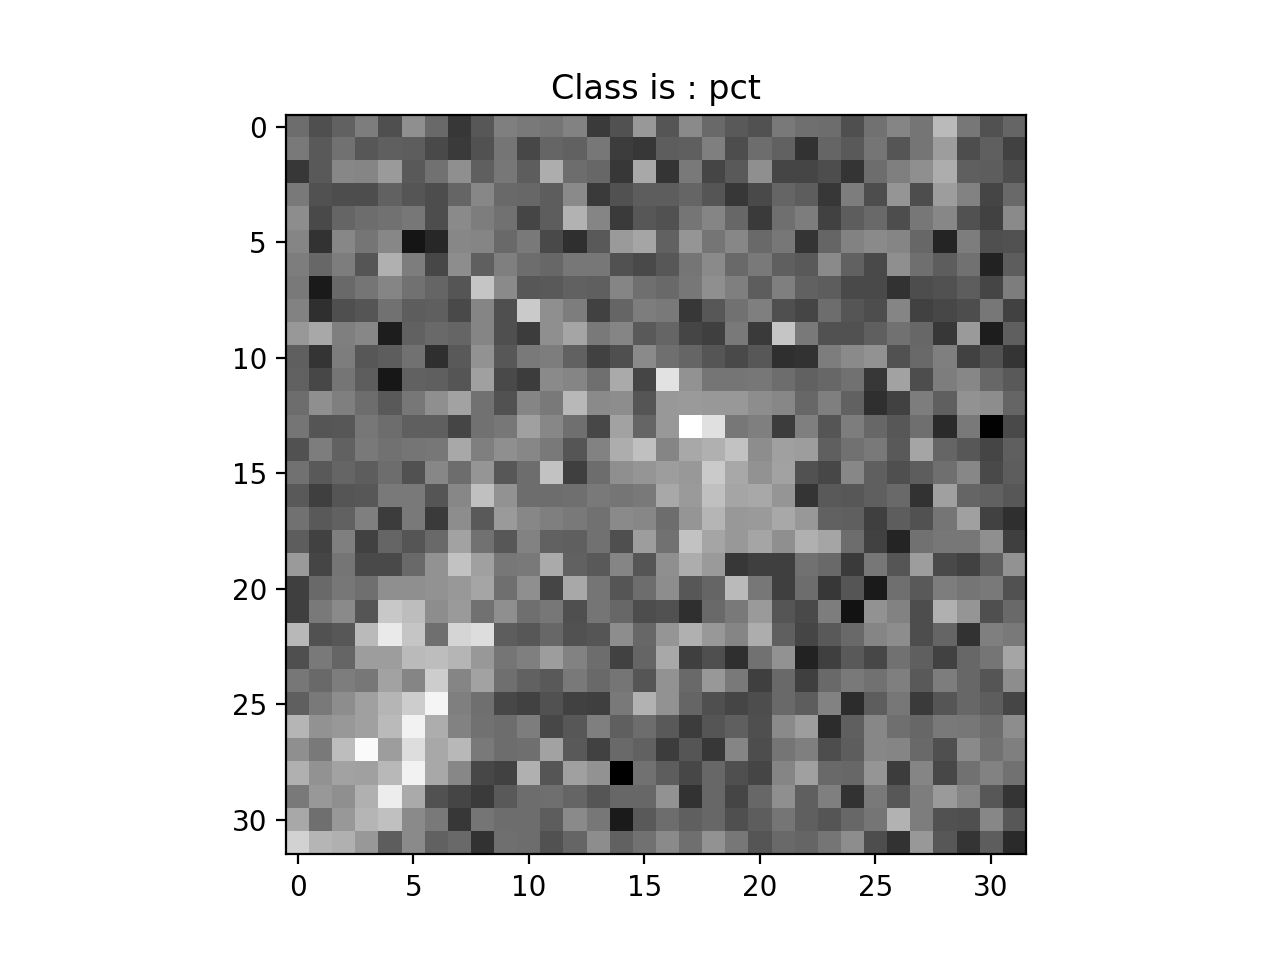

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [4]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [3]:
config_file = '../configs/config_hdf5_overlay.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [ ]:
# Train the network
main(config, None)

Total number of training images = 1946
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

    epoch          : 1
    loss           : 0.7754300534725189
    my_metric      : 0.5897836538461538
    f1             : 0.5590883939100547
    balanced_accuracy: 0.5378852980294082
    precision      : 0.5689640683987618
    recall         : 0.5897836538461538
    val_loss       : 0.630149757862091
    val_my_metric  : 0.6091071428571428
    val_f1         : 0.4635485849165729
    val_balanced_accuracy: 0.5
    val_precision  : 0.37614014668367346
    val_recall     : 0.6091071428571428
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.7421736487975488
    my_metric      : 0.5880791083916084
    f1             : 0.5533009464579647
    balanced_accuracy: 0.530328874845426
    precision      : 0.5704386007481307
    recall         : 0.5880791083916084
    val_loss       : 0.6511861920356751
    val_my_metric  : 0.5778571428571428
    val_f1         : 0

Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 0.7066849836936364
    my_metric      : 0.6148164335664336
    f1             : 0.5760365426339586
    balanced_accuracy: 0.5530688013562278
    precision      : 0.6011788506449762
    recall         : 0.6148164335664336
    val_loss       : 0.5392839431762695
    val_my_metric  : 0.7167857142857142
    val_f1         : 0.690585996201446
    val_balanced_accuracy: 0.6530430126482758
    val_precision  : 0.7364197078690004
    val_recall     : 0.7167857142857142
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 0.69059491616029
    my_metric      : 0.6418597027972027
    f1             : 0.6135351088135705
    balanced_accuracy: 0.586109881437206
    precision      : 0.6331050061138661
    recall         : 0.6418597027972027
    val_loss       : 0.5796248912811279
    val_my_metric  : 0.6663392857142857
    val_f1

Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 0.6485408223592318
    my_metric      : 0.660194493006993
    f1             : 0.6341274361230653
    balanced_accuracy: 0.6077911091256585
    precision      : 0.6608205465218295
    recall         : 0.660194493006993
    val_loss       : 0.5291308760643005
    val_my_metric  : 0.7141964285714286
    val_f1         : 0.6559931933129451
    val_balanced_accuracy: 0.6202394999839326
    val_precision  : 0.7923119674556149
    val_recall     : 0.7141964285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 0.6380661783310083
    my_metric      : 0.6606971153846154
    f1             : 0.6351486960976233
    balanced_accuracy: 0.6096444919693976
    precision      : 0.659817264447496
    recall         : 0.6606971153846154
    val_loss       : 0.493021035194397
    val_my_metric  : 0.7693749999999999
    val_f1

Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 0.5984091139756716
    my_metric      : 0.7065559440559441
    f1             : 0.6917642592333253
    balanced_accuracy: 0.6663193430011118
    precision      : 0.7100959903077284
    recall         : 0.7065559440559441
    val_loss       : 0.5046331286430359
    val_my_metric  : 0.7324107142857142
    val_f1         : 0.7177638856926304
    val_balanced_accuracy: 0.6843876062913848
    val_precision  : 0.7325658196178326
    val_recall     : 0.7324107142857142


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 0.6049671138708408
    my_metric      : 0.7159746503496505
    f1             : 0.7003633164657075
    balanced_accuracy: 0.6754824742813151
    precision      : 0.7221190178825078
    recall         : 0.7159746503496505
    val_loss       : 0.42316548228263856
    val_my_metric  : 0.7969642857142858
    val_f1         : 0.7900463827248672
    val_balanced_accuracy: 0.7628401521208275
    val_precision  : 0.8068323105193814
    val_recall     : 0.7969642857142858
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch10.pth ...
Saving current best: model_best.pth ...
    epoch          : 11
    loss           : 0.5465549001326928
    my_metric      : 0.7315996503496505
    f1             : 0.719117175986637
    balanced_accuracy: 0.6977379771399578
    precision      : 0.7402180907012917
    recall         : 0.7315996503496505
    val_loss       : 0.4286908388137817
    val_my_metric  : 0.7860714285714285
   

Model has not improved in -------------| 1 epochs


    epoch          : 12
    loss           : 0.5512160016940191
    my_metric      : 0.7263876748251749
    f1             : 0.7148370014973385
    balanced_accuracy: 0.690936140117452
    precision      : 0.7314524733162979
    recall         : 0.7263876748251749
    val_loss       : 0.5012175023555756
    val_my_metric  : 0.7605357142857143
    val_f1         : 0.7569320556802068
    val_balanced_accuracy: 0.7351866203971467
    val_precision  : 0.7598982518877907
    val_recall     : 0.7605357142857143


Model has not improved in -------------| 2 epochs


    epoch          : 13
    loss           : 0.5053576735349802
    my_metric      : 0.7508304195804196
    f1             : 0.7400764147031509
    balanced_accuracy: 0.7151408220854463
    precision      : 0.7591924340464163
    recall         : 0.7508304195804196
    val_loss       : 0.4740588843822479
    val_my_metric  : 0.7386607142857142
    val_f1         : 0.7123347321943925
    val_balanced_accuracy: 0.671119665022613
    val_precision  : 0.7634743383611918
    val_recall     : 0.7386607142857142


Model has not improved in -------------| 3 epochs


    epoch          : 14
    loss           : 0.5008845226122782
    my_metric      : 0.7435314685314686
    f1             : 0.7313275523042978
    balanced_accuracy: 0.7091275823079193
    precision      : 0.755231441250399
    recall         : 0.7435314685314686
    val_loss       : 0.4736992120742798
    val_my_metric  : 0.8089285714285713
    val_f1         : 0.8100248544099428
    val_balanced_accuracy: 0.7988678655102779
    val_precision  : 0.8156160829795794
    val_recall     : 0.8089285714285713


Model has not improved in -------------| 4 epochs


    epoch          : 15
    loss           : 0.4991532266139984
    my_metric      : 0.7501201923076923
    f1             : 0.7405338890026031
    balanced_accuracy: 0.7177218780034589
    precision      : 0.7594243208997867
    recall         : 0.7501201923076923
    val_loss       : 0.4721669614315033
    val_my_metric  : 0.7334821428571429
    val_f1         : 0.7107760644266697
    val_balanced_accuracy: 0.671917729591659
    val_precision  : 0.7495067020523204
    val_recall     : 0.7334821428571429


Model has not improved in -------------| 5 epochs


    epoch          : 16
    loss           : 0.5220800088002131
    my_metric      : 0.7437172202797202
    f1             : 0.7341933385292717
    balanced_accuracy: 0.711207532584258
    precision      : 0.7550083817369001
    recall         : 0.7437172202797202
    val_loss       : 0.4225699007511139
    val_my_metric  : 0.7844642857142857
    val_f1         : 0.7778931811724218
    val_balanced_accuracy: 0.7502776753423624
    val_precision  : 0.7867629662557067
    val_recall     : 0.7844642857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch16.pth ...
Saving current best: model_best.pth ...
    epoch          : 17
    loss           : 0.5231656844799335
    my_metric      : 0.7445148601398602
    f1             : 0.7329804442968099
    balanced_accuracy: 0.7082475220100111
    precision      : 0.7539552789171627
    recall         : 0.7445148601398602
    val_loss       : 0.5160439789295197
    val_my_metric  : 0.7375892857142857
    

Model has not improved in -------------| 1 epochs


    epoch          : 18
    loss           : 0.5348428980662272
    my_metric      : 0.7379042832167833
    f1             : 0.728098116461037
    balanced_accuracy: 0.7035081614550893
    precision      : 0.7443092120626709
    recall         : 0.7379042832167833
    val_loss       : 0.45507118105888367
    val_my_metric  : 0.7470535714285714
    val_f1         : 0.7179874867068416
    val_balanced_accuracy: 0.6819578810883159
    val_precision  : 0.7819209721776017
    val_recall     : 0.7470535714285714


Model has not improved in -------------| 2 epochs


    epoch          : 19
    loss           : 0.5205419659614563
    my_metric      : 0.753125
    f1             : 0.7421524236146084
    balanced_accuracy: 0.7184280342960137
    precision      : 0.7620834881746371
    recall         : 0.753125
    val_loss       : 0.4355363428592682
    val_my_metric  : 0.7641964285714286
    val_f1         : 0.7454722055986227
    val_balanced_accuracy: 0.7099613744401967
    val_precision  : 0.7917606413194649
    val_recall     : 0.7641964285714286


Model has not improved in -------------| 3 epochs


    epoch          : 20
    loss           : 0.4968044264958455
    my_metric      : 0.7465253496503497
    f1             : 0.7362910570552524
    balanced_accuracy: 0.7135209324788198
    precision      : 0.7583351962236204
    recall         : 0.7465253496503497
    val_loss       : 0.43588348627090456
    val_my_metric  : 0.7574107142857143
    val_f1         : 0.7362708590377709
    val_balanced_accuracy: 0.7003595955782657
    val_precision  : 0.783459767020467
    val_recall     : 0.7574107142857143


Model has not improved in -------------| 4 epochs


    epoch          : 21
    loss           : 0.5113806048264871
    my_metric      : 0.7396197552447552
    f1             : 0.7288734648459396
    balanced_accuracy: 0.7039062858962833
    precision      : 0.7500811870204831
    recall         : 0.7396197552447552
    val_loss       : 0.40879146456718446
    val_my_metric  : 0.7870535714285715
    val_f1         : 0.7731939163129427
    val_balanced_accuracy: 0.737650032762936
    val_precision  : 0.8051375248015873
    val_recall     : 0.7870535714285715
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch21.pth ...
Saving current best: model_best.pth ...
    epoch          : 22
    loss           : 0.5150604878480618
    my_metric      : 0.7559331293706294
    f1             : 0.7463978433287822
    balanced_accuracy: 0.7229847772263245
    precision      : 0.7698330797106585
    recall         : 0.7559331293706294
    val_loss       : 0.4244595289230347
    val_my_metric  : 0.8151785714285713
   

Model has not improved in -------------| 1 epochs


    epoch          : 23
    loss           : 0.5045938789844513
    my_metric      : 0.7353037587412588
    f1             : 0.723891987876097
    balanced_accuracy: 0.7035505838556818
    precision      : 0.7510738445033964
    recall         : 0.7353037587412588
    val_loss       : 0.4547024667263031
    val_my_metric  : 0.7958928571428572
    val_f1         : 0.7962162477394835
    val_balanced_accuracy: 0.7820672064899952
    val_precision  : 0.7990158821817303
    val_recall     : 0.7958928571428572


Model has not improved in -------------| 2 epochs


    epoch          : 24
    loss           : 0.4995012730360031
    my_metric      : 0.7582277097902098
    f1             : 0.7481799724468545
    balanced_accuracy: 0.7248890799097386
    precision      : 0.7621509732003382
    recall         : 0.7582277097902098
    val_loss       : 0.4592121183872223
    val_my_metric  : 0.7491071428571429
    val_f1         : 0.71578311376897
    val_balanced_accuracy: 0.677284142399232
    val_precision  : 0.7990766971515326
    val_recall     : 0.7491071428571429


Model has not improved in -------------| 3 epochs


    epoch          : 25
    loss           : 0.504189730836795
    my_metric      : 0.7534309440559441
    f1             : 0.7428939887163326
    balanced_accuracy: 0.7193740910491458
    precision      : 0.7648019030193892
    recall         : 0.7534309440559441
    val_loss       : 0.38381214141845704
    val_my_metric  : 0.7907142857142857
    val_f1         : 0.7810115078726303
    val_balanced_accuracy: 0.7515274199484725
    val_precision  : 0.8003831459123404
    val_recall     : 0.7907142857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.4935735727731998
    my_metric      : 0.7499235139860141
    f1             : 0.7392103193885184
    balanced_accuracy: 0.715531906939035
    precision      : 0.7604627735054437
    recall         : 0.7499235139860141
    val_loss       : 0.43059319257736206
    val_my_metric  : 0.8151785714285713
   

Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.4747687979386403
    my_metric      : 0.7694493006993006
    f1             : 0.7598941666539579
    balanced_accuracy: 0.7363592488914066
    precision      : 0.7788801954980992
    recall         : 0.7694493006993006
    val_loss       : 0.4236632287502289
    val_my_metric  : 0.7975
    val_f1         : 0.7854290491909831
    val_balanced_accuracy: 0.7476991093721599
    val_precision  : 0.8073066259356088
    val_recall     : 0.7975


Model has not improved in -------------| 2 epochs


    epoch          : 28
    loss           : 0.49041784268159133
    my_metric      : 0.7551354895104895
    f1             : 0.7454783632062967
    balanced_accuracy: 0.7212838940197943
    precision      : 0.7668279436511478
    recall         : 0.7551354895104895
    val_loss       : 0.4151946544647217
    val_my_metric  : 0.8000892857142856
    val_f1         : 0.7968919392328078
    val_balanced_accuracy: 0.7783383810527951
    val_precision  : 0.8035240329505935
    val_recall     : 0.8000892857142856


Model has not improved in -------------| 3 epochs


    epoch          : 29
    loss           : 0.4784526458153358
    my_metric      : 0.7660511363636364
    f1             : 0.7578740662657703
    balanced_accuracy: 0.736359407648647
    precision      : 0.7750377549968923
    recall         : 0.7660511363636364
    val_loss       : 0.43261214196681974
    val_my_metric  : 0.7766071428571428
    val_f1         : 0.7568936421398035
    val_balanced_accuracy: 0.7247192289022953
    val_precision  : 0.8027171332908252
    val_recall     : 0.7766071428571428


Model has not improved in -------------| 4 epochs


    epoch          : 30
    loss           : 0.49077413517695206
    my_metric      : 0.7560314685314685
    f1             : 0.7469103473575115
    balanced_accuracy: 0.7217680799353283
    precision      : 0.7626331470695443
    recall         : 0.7560314685314685
    val_loss       : 0.409050452709198
    val_my_metric  : 0.7975
    val_f1         : 0.7921085852017324
    val_balanced_accuracy: 0.7663348165109062
    val_precision  : 0.7986312057526498
    val_recall     : 0.7975


Model has not improved in -------------| 5 epochs


    epoch          : 31
    loss           : 0.48777023874796355
    my_metric      : 0.7682583041958042
    f1             : 0.7573758306386416
    balanced_accuracy: 0.7352788470541167
    precision      : 0.7814379695918551
    recall         : 0.7682583041958042
    val_loss       : 0.405560177564621
    val_my_metric  : 0.7875892857142858
    val_f1         : 0.767731025978624
    val_balanced_accuracy: 0.7216184371184372
    val_precision  : 0.8168769284183156
    val_recall     : 0.7875892857142858


Model has not improved in -------------| 6 epochs


    epoch          : 32
    loss           : 0.4735021327550595
    my_metric      : 0.7595388986013987
    f1             : 0.7492457324999463
    balanced_accuracy: 0.7251229513055417
    precision      : 0.7687372159065222
    recall         : 0.7595388986013987
    val_loss       : 0.46439029574394225
    val_my_metric  : 0.7224999999999999
    val_f1         : 0.6773127445600972
    val_balanced_accuracy: 0.6395082350599592
    val_precision  : 0.763825934432675
    val_recall     : 0.7224999999999999


Model has not improved in -------------| 7 epochs


    epoch          : 33
    loss           : 0.4870159729168965
    my_metric      : 0.7680506993006992
    f1             : 0.7593269132863714
    balanced_accuracy: 0.7385673358387386
    precision      : 0.7787699599187559
    recall         : 0.7680506993006992
    val_loss       : 0.391582316160202
    val_my_metric  : 0.7875892857142858
    val_f1         : 0.7765057620788507
    val_balanced_accuracy: 0.7407006097350924
    val_precision  : 0.7969060223354334
    val_recall     : 0.7875892857142858


Model has not improved in -------------| 8 epochs


    epoch          : 34
    loss           : 0.4639232571308429
    my_metric      : 0.7703562062937064
    f1             : 0.7606717027749093
    balanced_accuracy: 0.7387913086413568
    precision      : 0.7813530447654455
    recall         : 0.7703562062937064
    val_loss       : 0.39265472888946534
    val_my_metric  : 0.8245535714285713
    val_f1         : 0.8215983545706432
    val_balanced_accuracy: 0.8031627731627731
    val_precision  : 0.8258306339977851
    val_recall     : 0.8245535714285713


Model has not improved in -------------| 9 epochs


    epoch          : 35
    loss           : 0.4818587475098096
    my_metric      : 0.7633413461538462
    f1             : 0.7555739821208219
    balanced_accuracy: 0.7320324938278
    precision      : 0.7701040348241978
    recall         : 0.7633413461538462
    val_loss       : 0.4616060197353363
    val_my_metric  : 0.79125
    val_f1         : 0.788728379856259
    val_balanced_accuracy: 0.7710213101711219
    val_precision  : 0.7941521335440866
    val_recall     : 0.79125


Model has not improved in -------------| 10 epochs


    epoch          : 36
    loss           : 0.4820559059198086
    my_metric      : 0.7663461538461539
    f1             : 0.7574818050453717
    balanced_accuracy: 0.7359432806332252
    precision      : 0.7767204275804312
    recall         : 0.7663461538461539
    val_loss       : 0.41959900259971616
    val_my_metric  : 0.7777678571428572
    val_f1         : 0.7736309642643439
    val_balanced_accuracy: 0.7534430238785863
    val_precision  : 0.7816813761524499
    val_recall     : 0.7777678571428572


Model has not improved in -------------| 11 epochs


    epoch          : 37
    loss           : 0.4650438175751613
    my_metric      : 0.7709680944055944
    f1             : 0.7627695697125431
    balanced_accuracy: 0.7402960188002239
    precision      : 0.7810911100939981
    recall         : 0.7709680944055944
    val_loss       : 0.37291538119316103
    val_my_metric  : 0.8188392857142857
    val_f1         : 0.8109847923017602
    val_balanced_accuracy: 0.7813121235489656
    val_precision  : 0.8289505697715314
    val_recall     : 0.8188392857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch37.pth ...
Saving current best: model_best.pth ...
    epoch          : 38
    loss           : 0.45760959959947145
    my_metric      : 0.7699519230769231
    f1             : 0.7615058503449558
    balanced_accuracy: 0.7406267744042629
    precision      : 0.7803103053491426
    recall         : 0.7699519230769231
    val_loss       : 0.4782025098800659
    val_my_metric  : 0.7875892857142858
 

Model has not improved in -------------| 1 epochs


    epoch          : 39
    loss           : 0.46503757857359374
    my_metric      : 0.7692526223776224
    f1             : 0.7601277435311349
    balanced_accuracy: 0.737798525574725
    precision      : 0.7786590501504654
    recall         : 0.7692526223776224
    val_loss       : 0.41667341589927676
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8120931008870729
    val_balanced_accuracy: 0.7901387539324235
    val_precision  : 0.8171064574913306
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 2 epochs


    epoch          : 40
    loss           : 0.4500084828871947
    my_metric      : 0.7661385489510489
    f1             : 0.758792579248632
    balanced_accuracy: 0.7382519166576709
    precision      : 0.7728737096100858
    recall         : 0.7661385489510489
    val_loss       : 0.41502708196640015
    val_my_metric  : 0.7741071428571429
    val_f1         : 0.7549051361864899
    val_balanced_accuracy: 0.7219020305675933
    val_precision  : 0.8015679838112622
    val_recall     : 0.7741071428571429


Model has not improved in -------------| 3 epochs


    epoch          : 41
    loss           : 0.45746108431082505
    my_metric      : 0.7705638111888112
    f1             : 0.7628568024656541
    balanced_accuracy: 0.7430866599653944
    precision      : 0.7829167647071056
    recall         : 0.7705638111888112
    val_loss       : 0.39655176401138303
    val_my_metric  : 0.7886607142857143
    val_f1         : 0.7781817460150602
    val_balanced_accuracy: 0.7529958438554682
    val_precision  : 0.8007907904957141
    val_recall     : 0.7886607142857143


Model has not improved in -------------| 4 epochs


    epoch          : 42
    loss           : 0.467551222214332
    my_metric      : 0.7776770104895104
    f1             : 0.769575426746193
    balanced_accuracy: 0.748081187664803
    precision      : 0.7898243369791531
    recall         : 0.7776770104895104
    val_loss       : 0.4075234353542328
    val_my_metric  : 0.82875
    val_f1         : 0.8279981605786734
    val_balanced_accuracy: 0.812680273901204
    val_precision  : 0.8315727476007997
    val_recall     : 0.82875


Model has not improved in -------------| 5 epochs


    epoch          : 43
    loss           : 0.4368450057048064
    my_metric      : 0.7850852272727273
    f1             : 0.7773896103496957
    balanced_accuracy: 0.7567341293368297
    precision      : 0.7974263200844991
    recall         : 0.7850852272727273
    val_loss       : 0.4212359726428986
    val_my_metric  : 0.7741071428571429
    val_f1         : 0.7603932923701084
    val_balanced_accuracy: 0.7274284082191059
    val_precision  : 0.7886534013605442
    val_recall     : 0.7741071428571429


Model has not improved in -------------| 6 epochs


    epoch          : 44
    loss           : 0.4626600616253339
    my_metric      : 0.767646416083916
    f1             : 0.7594025333931067
    balanced_accuracy: 0.7365924433402621
    precision      : 0.7770738608924188
    recall         : 0.767646416083916
    val_loss       : 0.395079517364502
    val_my_metric  : 0.815625
    val_f1         : 0.8090187228111635
    val_balanced_accuracy: 0.7849891034637956
    val_precision  : 0.8150138200648737
    val_recall     : 0.815625


Model has not improved in -------------| 7 epochs


    epoch          : 45
    loss           : 0.45070600796204346
    my_metric      : 0.7813701923076923
    f1             : 0.7734716934922028
    balanced_accuracy: 0.752813538089832
    precision      : 0.7938997327609484
    recall         : 0.7813701923076923
    val_loss       : 0.3793788731098175
    val_my_metric  : 0.7886607142857143
    val_f1         : 0.7785289570965939
    val_balanced_accuracy: 0.747307042203003
    val_precision  : 0.7955812800374544
    val_recall     : 0.7886607142857143


Model has not improved in -------------| 8 epochs


    epoch          : 46
    loss           : 0.4638076894558393
    my_metric      : 0.7716564685314685
    f1             : 0.7624479799883235
    balanced_accuracy: 0.7397947954680407
    precision      : 0.7820450440811086
    recall         : 0.7716564685314685
    val_loss       : 0.4023288905620575
    val_my_metric  : 0.7886607142857143
    val_f1         : 0.7748798381066532
    val_balanced_accuracy: 0.7393662737875435
    val_precision  : 0.8042112600481811
    val_recall     : 0.7886607142857143


Model has not improved in -------------| 9 epochs


    epoch          : 47
    loss           : 0.4650366959663538
    my_metric      : 0.7639423076923078
    f1             : 0.7550735069884447
    balanced_accuracy: 0.7317005872536488
    precision      : 0.7738270716088563
    recall         : 0.7639423076923078
    val_loss       : 0.37234235405921934
    val_my_metric  : 0.8225
    val_f1         : 0.8175860482686209
    val_balanced_accuracy: 0.7948593297829776
    val_precision  : 0.8286837838357526
    val_recall     : 0.8225
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch47.pth ...
Saving current best: model_best.pth ...
    epoch          : 48
    loss           : 0.44468325261886305
    my_metric      : 0.7639532342657342
    f1             : 0.7564175540123348
    balanced_accuracy: 0.734108353860508
    precision      : 0.7724990002966242
    recall         : 0.7639532342657342
    val_loss       : 0.43460490703582766
    val_my_metric  : 0.7465178571428572
    val_f1         : 0.72

Model has not improved in -------------| 1 epochs


    epoch          : 49
    loss           : 0.45784053206443787
    my_metric      : 0.767854020979021
    f1             : 0.7587916013152787
    balanced_accuracy: 0.7409040086482802
    precision      : 0.780988224181956
    recall         : 0.767854020979021
    val_loss       : 0.4196767330169678
    val_my_metric  : 0.80375
    val_f1         : 0.8014033048268725
    val_balanced_accuracy: 0.7845954284315897
    val_precision  : 0.8037941896452416
    val_recall     : 0.80375


Model has not improved in -------------| 2 epochs


    epoch          : 50
    loss           : 0.4535014560589424
    my_metric      : 0.7690559440559441
    f1             : 0.7610782987417142
    balanced_accuracy: 0.7393920901241077
    precision      : 0.7765475481087686
    recall         : 0.7690559440559441
    val_loss       : 0.39519519209861753
    val_my_metric  : 0.7995535714285714
    val_f1         : 0.7864392101446431
    val_balanced_accuracy: 0.7508313790632531
    val_precision  : 0.8147542439178469
    val_recall     : 0.7995535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 51
    loss           : 0.4480642000069985
    my_metric      : 0.7705638111888112
    f1             : 0.7614656639841495
    balanced_accuracy: 0.743396424276532
    precision      : 0.7824460595683467
    recall         : 0.7705638111888112
    val_loss       : 0.38270344138145446
    val_my_metric  : 0.7714285714285715
    val_f1         : 0.7544680512589486
    val_balanced_accuracy: 0.7131573032702064
    val_precision  : 0.7858406805337366
    val_recall     : 0.7714285714285715


Model has not improved in -------------| 4 epochs


    epoch          : 52
    loss           : 0.4303252398967743
    my_metric      : 0.7777644230769231
    f1             : 0.7680209025346125
    balanced_accuracy: 0.7454946712043313
    precision      : 0.7897881366210324
    recall         : 0.7777644230769231
    val_loss       : 0.3836877465248108
    val_my_metric  : 0.8069642857142856
    val_f1         : 0.79942574611846
    val_balanced_accuracy: 0.7868856337460988
    val_precision  : 0.8301902648480258
    val_recall     : 0.8069642857142856


Model has not improved in -------------| 5 epochs


    epoch          : 53
    loss           : 0.4395194179736651
    my_metric      : 0.7792722902097903
    f1             : 0.7711898015818066
    balanced_accuracy: 0.7503110643361216
    precision      : 0.7896561392852672
    recall         : 0.7792722902097903
    val_loss       : 0.43401412963867186
    val_my_metric  : 0.82875
    val_f1         : 0.8305814821080416
    val_balanced_accuracy: 0.8359085479737655
    val_precision  : 0.8441491006262833
    val_recall     : 0.82875


Model has not improved in -------------| 6 epochs


    epoch          : 54
    loss           : 0.458224892616272
    my_metric      : 0.7783653846153846
    f1             : 0.7706181495539322
    balanced_accuracy: 0.7487814966436337
    precision      : 0.7868082759617242
    recall         : 0.7783653846153846
    val_loss       : 0.5017124831676483
    val_my_metric  : 0.7162499999999999
    val_f1         : 0.6597415588067235
    val_balanced_accuracy: 0.6244516120624495
    val_precision  : 0.7956176350996202
    val_recall     : 0.7162499999999999


Model has not improved in -------------| 7 epochs


    epoch          : 55
    loss           : 0.44689701612179095
    my_metric      : 0.7668487762237762
    f1             : 0.7579831779211794
    balanced_accuracy: 0.7342647390986586
    precision      : 0.7749350785420882
    recall         : 0.7668487762237762
    val_loss       : 0.37194602489471434
    val_my_metric  : 0.8199107142857143
    val_f1         : 0.815253984457898
    val_balanced_accuracy: 0.7921092060394386
    val_precision  : 0.8228099290415466
    val_recall     : 0.8199107142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch55.pth ...
Saving current best: model_best.pth ...
    epoch          : 56
    loss           : 0.43798929567520434
    my_metric      : 0.7794689685314685
    f1             : 0.7722334396816319
    balanced_accuracy: 0.7503336281855361
    precision      : 0.7874866117834962
    recall         : 0.7794689685314685
    val_loss       : 0.3560533285140991
    val_my_metric  : 0.8448214285714286
 

Model has not improved in -------------| 1 epochs


    epoch          : 58
    loss           : 0.4301581061803378
    my_metric      : 0.7824737762237762
    f1             : 0.7750530675708999
    balanced_accuracy: 0.7536469311847659
    precision      : 0.7930622069319124
    recall         : 0.7824737762237762
    val_loss       : 0.3848784267902374
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.831734401760562
    val_balanced_accuracy: 0.8162278925472328
    val_precision  : 0.8381325473239712
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 2 epochs


    epoch          : 59
    loss           : 0.4519341771419232
    my_metric      : 0.7701595279720279
    f1             : 0.7628003972416916
    balanced_accuracy: 0.7440160043504361
    precision      : 0.7828399673129034
    recall         : 0.7701595279720279
    val_loss       : 0.3842429995536804
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.83408906991236
    val_balanced_accuracy: 0.8141871987661462
    val_precision  : 0.8409311186346548
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 60
    loss           : 0.4269825999553387
    my_metric      : 0.786986451048951
    f1             : 0.7801873014628368
    balanced_accuracy: 0.7596391001377465
    precision      : 0.7956107282557444
    recall         : 0.786986451048951
    val_loss       : 0.4059791028499603
    val_my_metric  : 0.8079464285714286
    val_f1         : 0.8005264757073455
    val_balanced_accuracy: 0.7726276911494303
    val_precision  : 0.8142903809554471
    val_recall     : 0.8079464285714286


Model has not improved in -------------| 4 epochs


    epoch          : 61
    loss           : 0.4642898944708017
    my_metric      : 0.7744536713286714
    f1             : 0.7670592764682629
    balanced_accuracy: 0.7469586863397368
    precision      : 0.7874365000827216
    recall         : 0.7744536713286714
    val_loss       : 0.4010526418685913
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8285683051931911
    val_balanced_accuracy: 0.8256345233713654
    val_precision  : 0.8367329356456338
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 5 epochs


    epoch          : 62
    loss           : 0.4401960361462373
    my_metric      : 0.7796656468531468
    f1             : 0.7725337972123054
    balanced_accuracy: 0.7516346385762985
    precision      : 0.7903201781291824
    recall         : 0.7796656468531468
    val_loss       : 0.3925179958343506
    val_my_metric  : 0.8271428571428572
    val_f1         : 0.8254183967670811
    val_balanced_accuracy: 0.8054976956223528
    val_precision  : 0.8285789391909715
    val_recall     : 0.8271428571428572


Model has not improved in -------------| 6 epochs


    epoch          : 63
    loss           : 0.4422316768994698
    my_metric      : 0.7712631118881119
    f1             : 0.7613031821683616
    balanced_accuracy: 0.7414505321047525
    precision      : 0.7886606772560787
    recall         : 0.7712631118881119
    val_loss       : 0.3937619686126709
    val_my_metric  : 0.7709821428571428
    val_f1         : 0.758045394869756
    val_balanced_accuracy: 0.7233313603142244
    val_precision  : 0.7771764605284652
    val_recall     : 0.7709821428571428


Model has not improved in -------------| 7 epochs


    epoch          : 64
    loss           : 0.4405620258588057
    my_metric      : 0.7688592657342658
    f1             : 0.7606744085913585
    balanced_accuracy: 0.7420186395754216
    precision      : 0.7819349002847725
    recall         : 0.7688592657342658
    val_loss       : 0.3426936209201813
    val_my_metric  : 0.8375892857142857
    val_f1         : 0.834555167768643
    val_balanced_accuracy: 0.8182775356459567
    val_precision  : 0.8422058521704903
    val_recall     : 0.8375892857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch64.pth ...
Saving current best: model_best.pth ...
    epoch          : 65
    loss           : 0.4353833192816147
    my_metric      : 0.7873798076923078
    f1             : 0.7799629163965262
    balanced_accuracy: 0.7579677832264378
    precision      : 0.7974815042956837
    recall         : 0.7873798076923078
    val_loss       : 0.37625124454498293
    val_my_metric  : 0.8407142857142856
   

Model has not improved in -------------| 1 epochs


    epoch          : 66
    loss           : 0.4377225385262416
    my_metric      : 0.7808675699300699
    f1             : 0.7741675158421445
    balanced_accuracy: 0.7573244327328479
    precision      : 0.7944678600151621
    recall         : 0.7808675699300699
    val_loss       : 0.3948810875415802
    val_my_metric  : 0.7688392857142857
    val_f1         : 0.7417788455617257
    val_balanced_accuracy: 0.7023240210082314
    val_precision  : 0.8071851470288969
    val_recall     : 0.7688392857142857


Model has not improved in -------------| 2 epochs


    epoch          : 67
    loss           : 0.4351329356431961
    my_metric      : 0.7811625874125874
    f1             : 0.772192522095911
    balanced_accuracy: 0.7486493181258195
    precision      : 0.7906670188146738
    recall         : 0.7811625874125874
    val_loss       : 0.37170992493629457
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8363619361124606
    val_balanced_accuracy: 0.8217381646383461
    val_precision  : 0.8396922932756612
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 68
    loss           : 0.41683925917515385
    my_metric      : 0.7850743006993006
    f1             : 0.7773933435977429
    balanced_accuracy: 0.7580848671814308
    precision      : 0.7941496330130794
    recall         : 0.7850743006993006
    val_loss       : 0.4629388988018036
    val_my_metric  : 0.8167857142857142
    val_f1         : 0.8204484840177676
    val_balanced_accuracy: 0.825124597711425
    val_precision  : 0.835233018809489
    val_recall     : 0.8167857142857142


Model has not improved in -------------| 4 epochs


    epoch          : 69
    loss           : 0.45556846031775844
    my_metric      : 0.7752622377622378
    f1             : 0.76910538503861
    balanced_accuracy: 0.7490358661793274
    precision      : 0.7900702443241882
    recall         : 0.7752622377622378
    val_loss       : 0.3897774457931519
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8262776098944722
    val_balanced_accuracy: 0.8005175772539873
    val_precision  : 0.8421651211381296
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 5 epochs


    epoch          : 70
    loss           : 0.434528560592578
    my_metric      : 0.7852819055944056
    f1             : 0.7773424966271489
    balanced_accuracy: 0.7561467833753883
    precision      : 0.7952933977783877
    recall         : 0.7852819055944056
    val_loss       : 0.4407139360904694
    val_my_metric  : 0.7553571428571428
    val_f1         : 0.7413748360354714
    val_balanced_accuracy: 0.7082700895595633
    val_precision  : 0.7646223380759832
    val_recall     : 0.7553571428571428


Model has not improved in -------------| 6 epochs


    epoch          : 71
    loss           : 0.4360894881761991
    my_metric      : 0.7725633741258741
    f1             : 0.7628809056274469
    balanced_accuracy: 0.740118956827319
    precision      : 0.7842456829296091
    recall         : 0.7725633741258741
    val_loss       : 0.3690482169389725
    val_my_metric  : 0.8260714285714286
    val_f1         : 0.8210972780874097
    val_balanced_accuracy: 0.7954110227762361
    val_precision  : 0.8298416869616009
    val_recall     : 0.8260714285714286


Model has not improved in -------------| 7 epochs


    epoch          : 72
    loss           : 0.4127175802221665
    my_metric      : 0.7870738636363637
    f1             : 0.7795643973404355
    balanced_accuracy: 0.7572692035934325
    precision      : 0.7965546697063183
    recall         : 0.7870738636363637
    val_loss       : 0.3737586855888367
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8292222737121173
    val_balanced_accuracy: 0.8144646111707058
    val_precision  : 0.8382862164412508
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 8 epochs


    epoch          : 73
    loss           : 0.4146770995396834
    my_metric      : 0.7840799825174826
    f1             : 0.7773345657455187
    balanced_accuracy: 0.7571264724275468
    precision      : 0.792958717693595
    recall         : 0.7840799825174826
    val_loss       : 0.3514333963394165
    val_my_metric  : 0.8016964285714285
    val_f1         : 0.7879385184831527
    val_balanced_accuracy: 0.7573442065730926
    val_precision  : 0.8253551667654848
    val_recall     : 0.8016964285714285


Model has not improved in -------------| 9 epochs


    epoch          : 74
    loss           : 0.40966458733265215
    my_metric      : 0.7947006118881119
    f1             : 0.7882265290660467
    balanced_accuracy: 0.7708017774784016
    precision      : 0.809168651534454
    recall         : 0.7947006118881119
    val_loss       : 0.3722866833209991
    val_my_metric  : 0.8271428571428572
    val_f1         : 0.8248199169401561
    val_balanced_accuracy: 0.8147373094741516
    val_precision  : 0.830203380604814
    val_recall     : 0.8271428571428572


Model has not improved in -------------| 10 epochs


    epoch          : 75
    loss           : 0.4271306131894772
    my_metric      : 0.7815887237762238
    f1             : 0.7732383905863194
    balanced_accuracy: 0.7526246034604835
    precision      : 0.7950436154497441
    recall         : 0.7815887237762238
    val_loss       : 0.35960355401039124
    val_my_metric  : 0.850625
    val_f1         : 0.8492759784384496
    val_balanced_accuracy: 0.8370763845903264
    val_precision  : 0.853385873484315
    val_recall     : 0.850625


Model has not improved in -------------| 11 epochs


    epoch          : 76
    loss           : 0.4233882851325549
    my_metric      : 0.7785729895104895
    f1             : 0.7709365525210065
    balanced_accuracy: 0.7535925507737666
    precision      : 0.7935019494915625
    recall         : 0.7785729895104895
    val_loss       : 0.4040238976478577
    val_my_metric  : 0.7959821428571429
    val_f1         : 0.7934684325151851
    val_balanced_accuracy: 0.7768611253660845
    val_precision  : 0.7962242127390152
    val_recall     : 0.7959821428571429


Model has not improved in -------------| 12 epochs


    epoch          : 77
    loss           : 0.41461962919968826
    my_metric      : 0.7921875
    f1             : 0.7854388672168351
    balanced_accuracy: 0.7652508076688748
    precision      : 0.802625273524546
    recall         : 0.7921875
    val_loss       : 0.4000375986099243
    val_my_metric  : 0.7949107142857142
    val_f1         : 0.7810423354037127
    val_balanced_accuracy: 0.7427294909895233
    val_precision  : 0.8096773391398238
    val_recall     : 0.7949107142857142


Model has not improved in -------------| 13 epochs


    epoch          : 78
    loss           : 0.43942595559817094
    my_metric      : 0.7839816433566433
    f1             : 0.7783291971828099
    balanced_accuracy: 0.7576938233219039
    precision      : 0.7900779284138945
    recall         : 0.7839816433566433
    val_loss       : 0.3766888439655304
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.7922360387948096
    val_balanced_accuracy: 0.762999816178802
    val_precision  : 0.8182444223016156
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 14 epochs


    epoch          : 79
    loss           : 0.4138392817515593
    my_metric      : 0.7863745629370629
    f1             : 0.7784869595803227
    balanced_accuracy: 0.756210603298344
    precision      : 0.7937917908568362
    recall         : 0.7863745629370629
    val_loss       : 0.3655533969402313
    val_my_metric  : 0.8048214285714286
    val_f1         : 0.7938318198092634
    val_balanced_accuracy: 0.7645071982281285
    val_precision  : 0.8219949246623214
    val_recall     : 0.8048214285714286


Model has not improved in -------------| 15 epochs


    epoch          : 80
    loss           : 0.41590991387000453
    my_metric      : 0.775666520979021
    f1             : 0.767937637817407
    balanced_accuracy: 0.7467371889497636
    precision      : 0.7883800562374617
    recall         : 0.775666520979021
    val_loss       : 0.42997102737426757
    val_my_metric  : 0.7777678571428572
    val_f1         : 0.7591544565662971
    val_balanced_accuracy: 0.7211341887085594
    val_precision  : 0.7883435453803653
    val_recall     : 0.7777678571428572


Model has not improved in -------------| 16 epochs


    epoch          : 81
    loss           : 0.43137276287262255
    my_metric      : 0.7907998251748253
    f1             : 0.784199855680427
    balanced_accuracy: 0.7659018689128883
    precision      : 0.8015921222455137
    recall         : 0.7907998251748253
    val_loss       : 0.361014062166214
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.843227542675651
    val_balanced_accuracy: 0.8215592464362487
    val_precision  : 0.8457042020427137
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 17 epochs


    epoch          : 82
    loss           : 0.4000922762430631
    my_metric      : 0.8086101398601399
    f1             : 0.8024230914822178
    balanced_accuracy: 0.7807212243365824
    precision      : 0.8177502135221127
    recall         : 0.8086101398601399
    val_loss       : 0.38251513838768003
    val_my_metric  : 0.8146428571428572
    val_f1         : 0.8097667912740668
    val_balanced_accuracy: 0.7880411255411255
    val_precision  : 0.8207789749641661
    val_recall     : 0.8146428571428572


Model has not improved in -------------| 18 epochs


    epoch          : 83
    loss           : 0.42661089507433086
    my_metric      : 0.7663461538461539
    f1             : 0.7579820758032558
    balanced_accuracy: 0.7355742131603394
    precision      : 0.775329344480983
    recall         : 0.7663461538461539
    val_loss       : 0.3645787417888641
    val_my_metric  : 0.8016964285714285
    val_f1         : 0.7905997991589389
    val_balanced_accuracy: 0.758251988543625
    val_precision  : 0.8230407468773249
    val_recall     : 0.8016964285714285


Model has not improved in -------------| 19 epochs


    epoch          : 84
    loss           : 0.4174327449156688
    my_metric      : 0.7869755244755244
    f1             : 0.7800748275796855
    balanced_accuracy: 0.7617666044594633
    precision      : 0.8008939365234398
    recall         : 0.7869755244755244
    val_loss       : 0.3355906933546066
    val_my_metric  : 0.8411607142857143
    val_f1         : 0.8342449444556672
    val_balanced_accuracy: 0.811511631247823
    val_precision  : 0.8488117429489911
    val_recall     : 0.8411607142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch84.pth ...
Saving current best: model_best.pth ...
    epoch          : 85
    loss           : 0.4203461076204593
    my_metric      : 0.784965034965035
    f1             : 0.7777439363531733
    balanced_accuracy: 0.7549415377140185
    precision      : 0.7911339865379569
    recall         : 0.784965034965035
    val_loss       : 0.3397600591182709
    val_my_metric  : 0.8282142857142857
    va

Model has not improved in -------------| 1 epochs


    epoch          : 86
    loss           : 0.4171558744632281
    my_metric      : 0.7852819055944056
    f1             : 0.778168645056224
    balanced_accuracy: 0.7579214659201463
    precision      : 0.7962808328548803
    recall         : 0.7852819055944056
    val_loss       : 0.44643503427505493
    val_my_metric  : 0.7542857142857142
    val_f1         : 0.7342681704554452
    val_balanced_accuracy: 0.7019435810077023
    val_precision  : 0.7768228955866621
    val_recall     : 0.7542857142857142


Model has not improved in -------------| 2 epochs


    epoch          : 87
    loss           : 0.43481208555973494
    my_metric      : 0.7668487762237762
    f1             : 0.7584457999205563
    balanced_accuracy: 0.7366943694467882
    precision      : 0.7790185355072429
    recall         : 0.7668487762237762
    val_loss       : 0.38395588994026186
    val_my_metric  : 0.8219642857142857
    val_f1         : 0.8172926341113624
    val_balanced_accuracy: 0.7916294907828089
    val_precision  : 0.8237407426531396
    val_recall     : 0.8219642857142857


Model has not improved in -------------| 3 epochs


    epoch          : 88
    loss           : 0.40755719061081225
    my_metric      : 0.7865821678321679
    f1             : 0.7787416485931631
    balanced_accuracy: 0.7598079307719288
    precision      : 0.7972316523357141
    recall         : 0.7865821678321679
    val_loss       : 0.34993954598903654
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.8440997633670154
    val_balanced_accuracy: 0.8163798856392868
    val_precision  : 0.8626328033271937
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 4 epochs


    epoch          : 89
    loss           : 0.4136927918745921
    my_metric      : 0.7997049825174826
    f1             : 0.7940717992535382
    balanced_accuracy: 0.7789581902305679
    precision      : 0.8157389062679672
    recall         : 0.7997049825174826
    val_loss       : 0.38718129992485045
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8131617680758045
    val_balanced_accuracy: 0.7918146905263396
    val_precision  : 0.818019311417749
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 5 epochs


    epoch          : 90
    loss           : 0.4118456416405164
    my_metric      : 0.7952906468531468
    f1             : 0.7887862324161186
    balanced_accuracy: 0.7677070370755867
    precision      : 0.8070105643430062
    recall         : 0.7952906468531468
    val_loss       : 0.3665155440568924
    val_my_metric  : 0.8000892857142856
    val_f1         : 0.7893047373960778
    val_balanced_accuracy: 0.7513797343514679
    val_precision  : 0.8066310603485469
    val_recall     : 0.8000892857142856


Model has not improved in -------------| 6 epochs


    epoch          : 91
    loss           : 0.4106560464088733
    my_metric      : 0.7874781468531468
    f1             : 0.7811783247379972
    balanced_accuracy: 0.7625671001111785
    precision      : 0.7968583525339331
    recall         : 0.7874781468531468
    val_loss       : 0.3673895478248596
    val_my_metric  : 0.8167857142857142
    val_f1         : 0.8064077565891579
    val_balanced_accuracy: 0.7780252949037901
    val_precision  : 0.8228802238794504
    val_recall     : 0.8167857142857142


Model has not improved in -------------| 7 epochs


    epoch          : 92
    loss           : 0.41950094585235304
    my_metric      : 0.7959899475524476
    f1             : 0.7900211318514724
    balanced_accuracy: 0.7708806782773786
    precision      : 0.8069349608021537
    recall         : 0.7959899475524476
    val_loss       : 0.3732271373271942
    val_my_metric  : 0.8105357142857142
    val_f1         : 0.8034836504042275
    val_balanced_accuracy: 0.7716488911650202
    val_precision  : 0.8222264524028878
    val_recall     : 0.8105357142857142


Model has not improved in -------------| 8 epochs


    epoch          : 93
    loss           : 0.40060003789571613
    my_metric      : 0.7995957167832167
    f1             : 0.7935903423940907
    balanced_accuracy: 0.7728354817812911
    precision      : 0.8047953658250147
    recall         : 0.7995957167832167
    val_loss       : 0.3659412622451782
    val_my_metric  : 0.8011607142857142
    val_f1         : 0.7913460932364982
    val_balanced_accuracy: 0.7581988645854192
    val_precision  : 0.8238868582034231
    val_recall     : 0.8011607142857142


Model has not improved in -------------| 9 epochs


    epoch          : 94
    loss           : 0.41169058130337643
    my_metric      : 0.7905922202797202
    f1             : 0.7846838295132647
    balanced_accuracy: 0.7673820025517355
    precision      : 0.8000414566487886
    recall         : 0.7905922202797202
    val_loss       : 0.3788645565509796
    val_my_metric  : 0.8261607142857142
    val_f1         : 0.8233601240656038
    val_balanced_accuracy: 0.8062625114958095
    val_precision  : 0.8276100475740853
    val_recall     : 0.8261607142857142


Model has not improved in -------------| 10 epochs


    epoch          : 95
    loss           : 0.4016476170374797
    my_metric      : 0.7930944055944056
    f1             : 0.7871904780025687
    balanced_accuracy: 0.7699146757028029
    precision      : 0.8059065332235098
    recall         : 0.7930944055944056
    val_loss       : 0.3731480538845062
    val_my_metric  : 0.819375
    val_f1         : 0.8093745156887252
    val_balanced_accuracy: 0.7757764915816987
    val_precision  : 0.8380816921665367
    val_recall     : 0.819375


Model has not improved in -------------| 11 epochs


    epoch          : 96
    loss           : 0.42604259229623354
    my_metric      : 0.7796656468531468
    f1             : 0.7716101375440506
    balanced_accuracy: 0.7482254580769051
    precision      : 0.7880921649749061
    recall         : 0.7796656468531468
    val_loss       : 0.3901701807975769
    val_my_metric  : 0.7844642857142857
    val_f1         : 0.765859536016227
    val_balanced_accuracy: 0.7310183208007969
    val_precision  : 0.8185274363373797
    val_recall     : 0.7844642857142857


Model has not improved in -------------| 12 epochs


    epoch          : 97
    loss           : 0.39634348108218265
    my_metric      : 0.7961975524475525
    f1             : 0.7907938180559342
    balanced_accuracy: 0.7706553278225813
    precision      : 0.8020091287848048
    recall         : 0.7961975524475525
    val_loss       : 0.4141868889331818
    val_my_metric  : 0.8480357142857142
    val_f1         : 0.8484461868132135
    val_balanced_accuracy: 0.8376940913452048
    val_precision  : 0.8533680326584504
    val_recall     : 0.8480357142857142


Model has not improved in -------------| 13 epochs


    epoch          : 98
    loss           : 0.4126871182368352
    my_metric      : 0.786680506993007
    f1             : 0.7796708464302553
    balanced_accuracy: 0.7592014887627287
    precision      : 0.7944493450556617
    recall         : 0.786680506993007
    val_loss       : 0.3592221200466156
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.822701024378396
    val_balanced_accuracy: 0.8034207286965908
    val_precision  : 0.8272683500538408
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 14 epochs


    epoch          : 99
    loss           : 0.40535336159742796
    my_metric      : 0.7867788461538462
    f1             : 0.7801008176636915
    balanced_accuracy: 0.7614936155969622
    precision      : 0.7987525746649526
    recall         : 0.7867788461538462
    val_loss       : 0.43353018164634705
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8312607094965585
    val_balanced_accuracy: 0.8114980212426032
    val_precision  : 0.8316054552238763
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 15 epochs


    epoch          : 100
    loss           : 0.4178803196320167
    my_metric      : 0.7934003496503497
    f1             : 0.7882258978045813
    balanced_accuracy: 0.7693763079411711
    precision      : 0.8035114054939806
    recall         : 0.7934003496503497
    val_loss       : 0.38969592452049256
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8340593550922601
    val_balanced_accuracy: 0.8226542193438744
    val_precision  : 0.8361168445010323
    val_recall     : 0.8344642857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch100.pth ...


Model has not improved in -------------| 16 epochs


    epoch          : 101
    loss           : 0.41358403861522675
    my_metric      : 0.7948972902097903
    f1             : 0.789893470417067
    balanced_accuracy: 0.7707408651503722
    precision      : 0.8073143830667759
    recall         : 0.7948972902097903
    val_loss       : 0.3594349980354309
    val_my_metric  : 0.8110714285714286
    val_f1         : 0.8028487271247974
    val_balanced_accuracy: 0.7799162565132123
    val_precision  : 0.8275633481406508
    val_recall     : 0.8110714285714286


Model has not improved in -------------| 17 epochs


    epoch          : 102
    loss           : 0.39873090386390686
    my_metric      : 0.7978911713286714
    f1             : 0.7911047103526723
    balanced_accuracy: 0.7702995962077062
    precision      : 0.8083897691241126
    recall         : 0.7978911713286714
    val_loss       : 0.37342489361763
    val_my_metric  : 0.806875
    val_f1         : 0.795644374126517
    val_balanced_accuracy: 0.7646402896402897
    val_precision  : 0.8282859132025401
    val_recall     : 0.806875


Model has not improved in -------------| 18 epochs


    epoch          : 103
    loss           : 0.413387173643479
    my_metric      : 0.7903846153846155
    f1             : 0.7850606513939109
    balanced_accuracy: 0.765365695013243
    precision      : 0.8010500420411948
    recall         : 0.7903846153846155
    val_loss       : 0.3720438778400421
    val_my_metric  : 0.8360714285714286
    val_f1         : 0.8337295054296945
    val_balanced_accuracy: 0.813283020758724
    val_precision  : 0.8405888174325675
    val_recall     : 0.8360714285714286


Model has not improved in -------------| 19 epochs


    epoch          : 104
    loss           : 0.3950625749734732
    my_metric      : 0.786986451048951
    f1             : 0.7798827211709963
    balanced_accuracy: 0.7605844489238311
    precision      : 0.801730652107791
    recall         : 0.786986451048951
    val_loss       : 0.3558823764324188
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8268107374630411
    val_balanced_accuracy: 0.8059335418943021
    val_precision  : 0.8337680876641475
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 20 epochs


    epoch          : 105
    loss           : 0.406691591327007
    my_metric      : 0.7923951048951049
    f1             : 0.787380014333574
    balanced_accuracy: 0.7716297388528438
    precision      : 0.807005765231036
    recall         : 0.7923951048951049
    val_loss       : 0.3515488803386688
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8285884416956739
    val_balanced_accuracy: 0.8071755343779967
    val_precision  : 0.8340903407820669
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 21 epochs


    epoch          : 106
    loss           : 0.4100095537992624
    my_metric      : 0.7982954545454545
    f1             : 0.7927194331493255
    balanced_accuracy: 0.7739227179359146
    precision      : 0.8087085217964394
    recall         : 0.7982954545454545
    val_loss       : 0.3645636737346649
    val_my_metric  : 0.8032142857142857
    val_f1         : 0.7916497362529888
    val_balanced_accuracy: 0.7599119009645326
    val_precision  : 0.8183421889974378
    val_recall     : 0.8032142857142857


Model has not improved in -------------| 22 epochs


    epoch          : 107
    loss           : 0.4098918013847791
    my_metric      : 0.7930834790209791
    f1             : 0.7868754281051611
    balanced_accuracy: 0.7693074419659747
    precision      : 0.8069468343009167
    recall         : 0.7930834790209791
    val_loss       : 0.37384011745452883
    val_my_metric  : 0.8521428571428572
    val_f1         : 0.8520938682058242
    val_balanced_accuracy: 0.8441202773834352
    val_precision  : 0.8575337170774814
    val_recall     : 0.8521428571428572


Model has not improved in -------------| 23 epochs


    epoch          : 108
    loss           : 0.4072081377873054
    my_metric      : 0.7978911713286714
    f1             : 0.7923774490979222
    balanced_accuracy: 0.770520581177908
    precision      : 0.8070392300094736
    recall         : 0.7978911713286714
    val_loss       : 0.39363818764686587
    val_my_metric  : 0.7949107142857142
    val_f1         : 0.786756683436883
    val_balanced_accuracy: 0.7558223912501771
    val_precision  : 0.8017748670029012
    val_recall     : 0.7949107142857142


Model has not improved in -------------| 24 epochs


    epoch          : 109
    loss           : 0.4113342658831523
    my_metric      : 0.7855769230769231
    f1             : 0.7785898989074111
    balanced_accuracy: 0.7566199098871648
    precision      : 0.7961530201763196
    recall         : 0.7855769230769231
    val_loss       : 0.38050906658172606
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8274873800127361
    val_balanced_accuracy: 0.8010314691819687
    val_precision  : 0.8529875130702352
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 25 epochs


    epoch          : 110
    loss           : 0.3939086920939959
    my_metric      : 0.8002076048951049
    f1             : 0.7937559052720597
    balanced_accuracy: 0.7724409225455505
    precision      : 0.8109702892579145
    recall         : 0.8002076048951049
    val_loss       : 0.3701684892177582
    val_my_metric  : 0.8359821428571429
    val_f1         : 0.8331163552443585
    val_balanced_accuracy: 0.8183407161314138
    val_precision  : 0.8373443477549583
    val_recall     : 0.8359821428571429


Model has not improved in -------------| 26 epochs


    epoch          : 111
    loss           : 0.4085743702374972
    my_metric      : 0.7886909965034966
    f1             : 0.7817593580181443
    balanced_accuracy: 0.7603366862848764
    precision      : 0.7971447295911079
    recall         : 0.7886909965034966
    val_loss       : 0.3572744905948639
    val_my_metric  : 0.8188392857142857
    val_f1         : 0.8152220183680207
    val_balanced_accuracy: 0.7922899322899323
    val_precision  : 0.8185099863904213
    val_recall     : 0.8188392857142857


Model has not improved in -------------| 27 epochs


    epoch          : 112
    loss           : 0.3940798365152799
    my_metric      : 0.7936844405594405
    f1             : 0.7878753282690373
    balanced_accuracy: 0.7663164712002478
    precision      : 0.8049436674610593
    recall         : 0.7936844405594405
    val_loss       : 0.3527501106262207
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8289262214275496
    val_balanced_accuracy: 0.8111392123571971
    val_precision  : 0.8316634875541127
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 28 epochs


    epoch          : 113
    loss           : 0.40503996496017164
    my_metric      : 0.7938920454545454
    f1             : 0.7871906397510707
    balanced_accuracy: 0.7674325326720624
    precision      : 0.8016512487430705
    recall         : 0.7938920454545454
    val_loss       : 0.34895418882369994
    val_my_metric  : 0.8448214285714286
    val_f1         : 0.8425352565751867
    val_balanced_accuracy: 0.8230991924300515
    val_precision  : 0.8455832775179015
    val_recall     : 0.8448214285714286


Model has not improved in -------------| 29 epochs


    epoch          : 114
    loss           : 0.3934085059624452
    my_metric      : 0.8017045454545454
    f1             : 0.7959741177964996
    balanced_accuracy: 0.7778970582467848
    precision      : 0.8124532391000934
    recall         : 0.8017045454545454
    val_loss       : 0.36348427534103395
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8237228330673932
    val_balanced_accuracy: 0.7991366966366966
    val_precision  : 0.832111479567085
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 30 epochs


    epoch          : 115
    loss           : 0.40828105348807114
    my_metric      : 0.8025131118881119
    f1             : 0.796971110552411
    balanced_accuracy: 0.7809821758498731
    precision      : 0.8142702613749211
    recall         : 0.8025131118881119
    val_loss       : 0.33517534136772154
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.8438387854758034
    val_balanced_accuracy: 0.8150003939131295
    val_precision  : 0.8659229419040344
    val_recall     : 0.8500892857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch115.pth ...
Saving current best: model_best.pth ...
    epoch          : 116
    loss           : 0.3933845368715433
    my_metric      : 0.7962958916083915
    f1             : 0.7900864554143752
    balanced_accuracy: 0.7705083604512085
    precision      : 0.8045426883209956
    recall         : 0.7962958916083915
    val_loss       : 0.38787124752998353
    val_my_metric  : 0.819375
    val_

Model has not improved in -------------| 1 epochs


    epoch          : 117
    loss           : 0.4087245945747082
    my_metric      : 0.787784090909091
    f1             : 0.782981422248766
    balanced_accuracy: 0.7636388479381877
    precision      : 0.7946492540568239
    recall         : 0.787784090909091
    val_loss       : 0.3963650107383728
    val_my_metric  : 0.8302678571428572
    val_f1         : 0.8303768406096615
    val_balanced_accuracy: 0.8213123816702821
    val_precision  : 0.8305723443223443
    val_recall     : 0.8302678571428572


Model has not improved in -------------| 2 epochs


    epoch          : 118
    loss           : 0.4093448450932136
    my_metric      : 0.7935861013986014
    f1             : 0.7890414285722588
    balanced_accuracy: 0.7703431113884949
    precision      : 0.8010726249381656
    recall         : 0.7935861013986014
    val_loss       : 0.3605854332447052
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8062630509502963
    val_balanced_accuracy: 0.774383992660769
    val_precision  : 0.827558810754463
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 3 epochs


    epoch          : 119
    loss           : 0.4118695706129074
    my_metric      : 0.7924934440559441
    f1             : 0.7874419658995362
    balanced_accuracy: 0.7684230793554754
    precision      : 0.8030846703740069
    recall         : 0.7924934440559441
    val_loss       : 0.4174156665802002
    val_my_metric  : 0.8022321428571428
    val_f1         : 0.8013773474071322
    val_balanced_accuracy: 0.7907669746301771
    val_precision  : 0.8078460279440997
    val_recall     : 0.8022321428571428


Model has not improved in -------------| 4 epochs


    epoch          : 120
    loss           : 0.3912811497083077
    my_metric      : 0.8060096153846155
    f1             : 0.7996154412230182
    balanced_accuracy: 0.7810564480557944
    precision      : 0.8209654457487444
    recall         : 0.8060096153846155
    val_loss       : 0.37858020663261416
    val_my_metric  : 0.8178571428571428
    val_f1         : 0.8158279255267882
    val_balanced_accuracy: 0.7995870500377393
    val_precision  : 0.8187826597891336
    val_recall     : 0.8178571428571428


Model has not improved in -------------| 5 epochs


    epoch          : 121
    loss           : 0.39145097996179873
    my_metric      : 0.8
    f1             : 0.7938429719745336
    balanced_accuracy: 0.7773458748037503
    precision      : 0.8106289533949792
    recall         : 0.8
    val_loss       : 0.37131727337837217
    val_my_metric  : 0.8120535714285714
    val_f1         : 0.8071431450756513
    val_balanced_accuracy: 0.7864018299122338
    val_precision  : 0.8119958921306891
    val_recall     : 0.8120535714285714


Model has not improved in -------------| 6 epochs


    epoch          : 122
    loss           : 0.41293942584441257
    my_metric      : 0.7986997377622378
    f1             : 0.7936142506085416
    balanced_accuracy: 0.7752533818028411
    precision      : 0.8055630496951738
    recall         : 0.7986997377622378
    val_loss       : 0.3564877212047577
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.837958592704543
    val_balanced_accuracy: 0.8094927616842801
    val_precision  : 0.8483917606357814
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 7 epochs


    epoch          : 123
    loss           : 0.4011417501247846
    my_metric      : 0.7948972902097903
    f1             : 0.7881933721869955
    balanced_accuracy: 0.7714779673730858
    precision      : 0.809283925017102
    recall         : 0.7948972902097903
    val_loss       : 0.35754022002220154
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8077841879266426
    val_balanced_accuracy: 0.7718862679915313
    val_precision  : 0.8229995509260675
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 8 epochs


    epoch          : 124
    loss           : 0.3978226906978167
    my_metric      : 0.8003059440559441
    f1             : 0.7951552640713881
    balanced_accuracy: 0.7775244133359972
    precision      : 0.8115540739585825
    recall         : 0.8003059440559441
    val_loss       : 0.3591662168502808
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8432317694325144
    val_balanced_accuracy: 0.822748908985751
    val_precision  : 0.8503984177277084
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 9 epochs


    epoch          : 125
    loss           : 0.4118253944011835
    my_metric      : 0.7937937062937064
    f1             : 0.7884381788432399
    balanced_accuracy: 0.7707264195656547
    precision      : 0.8022026345683938
    recall         : 0.7937937062937064
    val_loss       : 0.367768383026123
    val_my_metric  : 0.8407142857142856
    val_f1         : 0.8392377185398677
    val_balanced_accuracy: 0.8242269457349657
    val_precision  : 0.8449150114591291
    val_recall     : 0.8407142857142856


Model has not improved in -------------| 10 epochs


    epoch          : 126
    loss           : 0.4007747322320938
    my_metric      : 0.7958916083916083
    f1             : 0.7895370594663667
    balanced_accuracy: 0.770992156361555
    precision      : 0.8053510615350945
    recall         : 0.7958916083916083
    val_loss       : 0.3736456036567688
    val_my_metric  : 0.7995535714285714
    val_f1         : 0.7876787788118446
    val_balanced_accuracy: 0.7591442937954566
    val_precision  : 0.809262309119452
    val_recall     : 0.7995535714285714


Model has not improved in -------------| 11 epochs


    epoch          : 127
    loss           : 0.41965593282993024
    my_metric      : 0.7931818181818181
    f1             : 0.7861957595406014
    balanced_accuracy: 0.7648264812968547
    precision      : 0.7999272306793015
    recall         : 0.7931818181818181
    val_loss       : 0.3453310042619705
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8317927320271481
    val_balanced_accuracy: 0.8052972612183138
    val_precision  : 0.8425036245911114
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 12 epochs


    epoch          : 128
    loss           : 0.3984300849529413
    my_metric      : 0.806708916083916
    f1             : 0.8016153718162943
    balanced_accuracy: 0.7830531942966841
    precision      : 0.8130527049897847
    recall         : 0.806708916083916
    val_loss       : 0.3646359145641327
    val_my_metric  : 0.835
    val_f1         : 0.8338522909900596
    val_balanced_accuracy: 0.8164666004390287
    val_precision  : 0.8356626057017096
    val_recall     : 0.835


Model has not improved in -------------| 13 epochs


    epoch          : 129
    loss           : 0.3941843268963007
    my_metric      : 0.7993006993006992
    f1             : 0.7928546774027954
    balanced_accuracy: 0.7729146494512817
    precision      : 0.810112881258783
    recall         : 0.7993006993006992
    val_loss       : 0.3463125228881836
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8063963582522142
    val_balanced_accuracy: 0.7774750871476139
    val_precision  : 0.8345417228751446
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 14 epochs


    epoch          : 130
    loss           : 0.40321188591993773
    my_metric      : 0.7941870629370629
    f1             : 0.7886733476474557
    balanced_accuracy: 0.7724668546251163
    precision      : 0.8045459017719874
    recall         : 0.7941870629370629
    val_loss       : 0.34289591312408446
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8360289006103094
    val_balanced_accuracy: 0.8164319664284602
    val_precision  : 0.842095689098995
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 15 epochs


    epoch          : 131
    loss           : 0.39660040862285173
    my_metric      : 0.7978037587412588
    f1             : 0.7917846000262828
    balanced_accuracy: 0.7714055250153712
    precision      : 0.8090280610488553
    recall         : 0.7978037587412588
    val_loss       : 0.35756288170814515
    val_my_metric  : 0.8298214285714286
    val_f1         : 0.8258190290147425
    val_balanced_accuracy: 0.8032727256768177
    val_precision  : 0.8353870307324256
    val_recall     : 0.8298214285714286


Model has not improved in -------------| 16 epochs


    epoch          : 132
    loss           : 0.41151901850333583
    my_metric      : 0.7892919580419581
    f1             : 0.7829404188360196
    balanced_accuracy: 0.7638771084135972
    precision      : 0.8015943938622936
    recall         : 0.7892919580419581
    val_loss       : 0.3650097191333771
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8422146988159259
    val_balanced_accuracy: 0.8226645862710773
    val_precision  : 0.8499279515896772
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 17 epochs


    epoch          : 133
    loss           : 0.38611058031137174
    my_metric      : 0.7963833041958043
    f1             : 0.7905370007796451
    balanced_accuracy: 0.7735898869230005
    precision      : 0.8048673156426251
    recall         : 0.7963833041958043
    val_loss       : 0.34621028900146483
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8306140421538943
    val_balanced_accuracy: 0.8120971659919028
    val_precision  : 0.8376888111958258
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 18 epochs


    epoch          : 134
    loss           : 0.40474395339305586
    my_metric      : 0.7869755244755244
    f1             : 0.7811627310341507
    balanced_accuracy: 0.761316764584708
    precision      : 0.793501395542484
    recall         : 0.7869755244755244
    val_loss       : 0.31305311024189
    val_my_metric  : 0.8573214285714286
    val_f1         : 0.8522797126979949
    val_balanced_accuracy: 0.8232059851533536
    val_precision  : 0.8616532681499788
    val_recall     : 0.8573214285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch134.pth ...
Saving current best: model_best.pth ...
    epoch          : 135
    loss           : 0.3947080557162945
    my_metric      : 0.8078125
    f1             : 0.8015401749059848
    balanced_accuracy: 0.7824671598278793
    precision      : 0.818476417506331
    recall         : 0.8078125
    val_loss       : 0.34891656935215
    val_my_metric  : 0.7855357142857142
    val_f1         : 0.7

Model has not improved in -------------| 1 epochs


    epoch          : 136
    loss           : 0.41556820273399353
    my_metric      : 0.7950939685314685
    f1             : 0.7903387969758163
    balanced_accuracy: 0.7711947178957094
    precision      : 0.802520882334363
    recall         : 0.7950939685314685
    val_loss       : 0.3595764696598053
    val_my_metric  : 0.8412499999999999
    val_f1         : 0.8388241321987678
    val_balanced_accuracy: 0.8305384027684608
    val_precision  : 0.8525703463203463
    val_recall     : 0.8412499999999999


Model has not improved in -------------| 2 epochs


    epoch          : 137
    loss           : 0.39533606744729555
    my_metric      : 0.7920891608391608
    f1             : 0.7861460190398382
    balanced_accuracy: 0.7676091709668241
    precision      : 0.80172799577041
    recall         : 0.7920891608391608
    val_loss       : 0.34740460515022276
    val_my_metric  : 0.8099999999999999
    val_f1         : 0.806591559481781
    val_balanced_accuracy: 0.7832504847881305
    val_precision  : 0.8096217823479815
    val_recall     : 0.8099999999999999


Model has not improved in -------------| 3 epochs


    epoch          : 138
    loss           : 0.3909653826401784
    my_metric      : 0.7965909090909091
    f1             : 0.791155407187863
    balanced_accuracy: 0.7732125188476561
    precision      : 0.8071543998582189
    recall         : 0.7965909090909091
    val_loss       : 0.37924330234527587
    val_my_metric  : 0.8261607142857142
    val_f1         : 0.8233926348723097
    val_balanced_accuracy: 0.806044277360067
    val_precision  : 0.8305901091739727
    val_recall     : 0.8261607142857142


Model has not improved in -------------| 4 epochs


    epoch          : 139
    loss           : 0.3957478209183766
    my_metric      : 0.8076158216783218
    f1             : 0.8021408723940316
    balanced_accuracy: 0.7820400548550258
    precision      : 0.814545457835625
    recall         : 0.8076158216783218
    val_loss       : 0.3491539001464844
    val_my_metric  : 0.8241071428571429
    val_f1         : 0.8201935193658766
    val_balanced_accuracy: 0.7995632931446885
    val_precision  : 0.8285952158899086
    val_recall     : 0.8241071428571429


Model has not improved in -------------| 5 epochs


    epoch          : 140
    loss           : 0.39592505074464357
    my_metric      : 0.7982954545454545
    f1             : 0.7914761511844345
    balanced_accuracy: 0.7684080092864163
    precision      : 0.8058331138175556
    recall         : 0.7982954545454545
    val_loss       : 0.37213772535324097
    val_my_metric  : 0.8547321428571429
    val_f1         : 0.8532342434927532
    val_balanced_accuracy: 0.8368636499683829
    val_precision  : 0.8561219628239977
    val_recall     : 0.8547321428571429


Model has not improved in -------------| 6 epochs


    epoch          : 141
    loss           : 0.3901898574370604
    my_metric      : 0.7989947552447553
    f1             : 0.7933593038300546
    balanced_accuracy: 0.7731822501193939
    precision      : 0.805750063413243
    recall         : 0.7989947552447553
    val_loss       : 0.3586995482444763
    val_my_metric  : 0.8235714285714286
    val_f1         : 0.814571118480176
    val_balanced_accuracy: 0.7967264259262423
    val_precision  : 0.8439876693712286
    val_recall     : 0.8235714285714286


Model has not improved in -------------| 7 epochs


    epoch          : 142
    loss           : 0.3926319915514726
    my_metric      : 0.8051027097902098
    f1             : 0.7997972354532281
    balanced_accuracy: 0.7836275654120293
    precision      : 0.8157149489162656
    recall         : 0.8051027097902098
    val_loss       : 0.34253659248352053
    val_my_metric  : 0.8631249999999999
    val_f1         : 0.8609783489070182
    val_balanced_accuracy: 0.8384177175377383
    val_precision  : 0.8630458328156119
    val_recall     : 0.8631249999999999


Model has not improved in -------------| 8 epochs


    epoch          : 143
    loss           : 0.4102504150225566
    my_metric      : 0.7902862762237762
    f1             : 0.785077148976761
    balanced_accuracy: 0.7684969032868747
    precision      : 0.801065378918866
    recall         : 0.7902862762237762
    val_loss       : 0.3501420795917511
    val_my_metric  : 0.8417857142857142
    val_f1         : 0.8395143379123302
    val_balanced_accuracy: 0.824726608560758
    val_precision  : 0.843096144925628
    val_recall     : 0.8417857142857142


Model has not improved in -------------| 9 epochs


    epoch          : 144
    loss           : 0.3947100215233289
    my_metric      : 0.7938920454545454
    f1             : 0.7885762985041423
    balanced_accuracy: 0.7694979252095787
    precision      : 0.8006710151111542
    recall         : 0.7938920454545454
    val_loss       : 0.34933185279369355
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8321648433730188
    val_balanced_accuracy: 0.8136917614549193
    val_precision  : 0.8352828434204824
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 10 epochs


    epoch          : 145
    loss           : 0.38911060988903046
    my_metric      : 0.8046110139860141
    f1             : 0.7998407435862777
    balanced_accuracy: 0.7831934297725728
    precision      : 0.8135653808394392
    recall         : 0.8046110139860141
    val_loss       : 0.3593719661235809
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8271026836086094
    val_balanced_accuracy: 0.7906872768714874
    val_precision  : 0.8294810567339637
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 11 epochs


    epoch          : 146
    loss           : 0.3897442256028836
    my_metric      : 0.8087194055944056
    f1             : 0.8040665172931984
    balanced_accuracy: 0.7843507091822779
    precision      : 0.8165521543344685
    recall         : 0.8087194055944056
    val_loss       : 0.3367574632167816
    val_my_metric  : 0.8547321428571429
    val_f1         : 0.8522423578705371
    val_balanced_accuracy: 0.8417475212959085
    val_precision  : 0.8650239399318045
    val_recall     : 0.8547321428571429


Model has not improved in -------------| 12 epochs


    epoch          : 147
    loss           : 0.3839081692007872
    my_metric      : 0.8087194055944056
    f1             : 0.8031826765987764
    balanced_accuracy: 0.7868252930923899
    precision      : 0.8175479678313355
    recall         : 0.8087194055944056
    val_loss       : 0.38298262357711793
    val_my_metric  : 0.813125
    val_f1         : 0.8095245214981208
    val_balanced_accuracy: 0.784182393388488
    val_precision  : 0.8177589578369668
    val_recall     : 0.813125


Model has not improved in -------------| 13 epochs


    epoch          : 148
    loss           : 0.3927464995246667
    my_metric      : 0.8080091783216783
    f1             : 0.8030639384249904
    balanced_accuracy: 0.7849758322512462
    precision      : 0.8164852250308414
    recall         : 0.8080091783216783
    val_loss       : 0.3546875476837158
    val_my_metric  : 0.8225
    val_f1         : 0.8198904866482513
    val_balanced_accuracy: 0.8022764930232397
    val_precision  : 0.8245343200315155
    val_recall     : 0.8225


Model has not improved in -------------| 14 epochs


    epoch          : 149
    loss           : 0.387661948800087
    my_metric      : 0.8051136363636364
    f1             : 0.7992371019438489
    balanced_accuracy: 0.7804766704503626
    precision      : 0.8129364018300502
    recall         : 0.8051136363636364
    val_loss       : 0.3638382971286774
    val_my_metric  : 0.8116071428571429
    val_f1         : 0.8022872856632357
    val_balanced_accuracy: 0.7781775087657441
    val_precision  : 0.8176394879064874
    val_recall     : 0.8116071428571429


Model has not improved in -------------| 15 epochs


    epoch          : 150
    loss           : 0.4040445272739117
    my_metric      : 0.7962958916083915
    f1             : 0.7896675173338479
    balanced_accuracy: 0.768957850745851
    precision      : 0.8042580411485326
    recall         : 0.7962958916083915
    val_loss       : 0.33053854405879973
    val_my_metric  : 0.848482142857143
    val_f1         : 0.8451074335765515
    val_balanced_accuracy: 0.8263056798056798
    val_precision  : 0.8549145500591541
    val_recall     : 0.848482142857143


Model has not improved in -------------| 16 epochs


    epoch          : 151
    loss           : 0.39609324645537597
    my_metric      : 0.8016936188811189
    f1             : 0.7966091312204342
    balanced_accuracy: 0.778484035844985
    precision      : 0.8098745746397705
    recall         : 0.8016936188811189
    val_loss       : 0.37501307129859923
    val_my_metric  : 0.8225
    val_f1         : 0.8196430764679267
    val_balanced_accuracy: 0.786108542798198
    val_precision  : 0.8240378751127004
    val_recall     : 0.8225


Model has not improved in -------------| 17 epochs


    epoch          : 152
    loss           : 0.405851695400018
    my_metric      : 0.7866914335664336
    f1             : 0.7808919806675927
    balanced_accuracy: 0.7617060404053713
    precision      : 0.7937627020386739
    recall         : 0.7866914335664336
    val_loss       : 0.357011204957962
    val_my_metric  : 0.838125
    val_f1         : 0.8365028025569667
    val_balanced_accuracy: 0.821872769508639
    val_precision  : 0.8505919959607361
    val_recall     : 0.838125


Model has not improved in -------------| 18 epochs


    epoch          : 153
    loss           : 0.3876525198037808
    my_metric      : 0.8107080419580419
    f1             : 0.8058498381285464
    balanced_accuracy: 0.7869874082350561
    precision      : 0.8196607492580452
    recall         : 0.8107080419580419
    val_loss       : 0.35126079320907594
    val_my_metric  : 0.8464285714285713
    val_f1         : 0.8438944463273292
    val_balanced_accuracy: 0.8357975708502023
    val_precision  : 0.8587628359323014
    val_recall     : 0.8464285714285713


Model has not improved in -------------| 19 epochs


    epoch          : 154
    loss           : 0.3842030339516126
    my_metric      : 0.7957932692307692
    f1             : 0.7889993394946851
    balanced_accuracy: 0.769725405931466
    precision      : 0.8080756521458375
    recall         : 0.7957932692307692
    val_loss       : 0.36146503388881684
    val_my_metric  : 0.8146428571428572
    val_f1         : 0.8034039009608259
    val_balanced_accuracy: 0.7698251408278854
    val_precision  : 0.8288054922255317
    val_recall     : 0.8146428571428572


Model has not improved in -------------| 20 epochs


    epoch          : 155
    loss           : 0.3750631379393431
    my_metric      : 0.8106206293706294
    f1             : 0.8054134306365311
    balanced_accuracy: 0.7877214857105508
    precision      : 0.8200892750504456
    recall         : 0.8106206293706294
    val_loss       : 0.3652232110500336
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8196587664370083
    val_balanced_accuracy: 0.7949269699714808
    val_precision  : 0.8322250948500944
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 21 epochs


    epoch          : 156
    loss           : 0.39278597556627715
    my_metric      : 0.7993990384615385
    f1             : 0.7951593154967055
    balanced_accuracy: 0.7772312434125546
    precision      : 0.810477575941802
    recall         : 0.7993990384615385
    val_loss       : 0.36728503108024596
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8331967650885078
    val_balanced_accuracy: 0.8137703642819922
    val_precision  : 0.84093008019243
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 22 epochs


    epoch          : 157
    loss           : 0.39177494324170625
    my_metric      : 0.8084134615384616
    f1             : 0.8039104810756447
    balanced_accuracy: 0.7847204540405752
    precision      : 0.8164537289609483
    recall         : 0.8084134615384616
    val_loss       : 0.3416982412338257
    val_my_metric  : 0.8391964285714286
    val_f1         : 0.8355799180571278
    val_balanced_accuracy: 0.8105123582673954
    val_precision  : 0.8466119646353867
    val_recall     : 0.8391964285714286


Model has not improved in -------------| 23 epochs


    epoch          : 158
    loss           : 0.3985583403935799
    my_metric      : 0.7902862762237762
    f1             : 0.7852538508453601
    balanced_accuracy: 0.7673774609937103
    precision      : 0.80099248092067
    recall         : 0.7902862762237762
    val_loss       : 0.36104960441589357
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.831751261360907
    val_balanced_accuracy: 0.8218999676638002
    val_precision  : 0.8403754525401679
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 24 epochs


    epoch          : 159
    loss           : 0.3852732754670657
    my_metric      : 0.7980004370629371
    f1             : 0.7925214791068551
    balanced_accuracy: 0.7720067026611793
    precision      : 0.8049427357972083
    recall         : 0.7980004370629371
    val_loss       : 0.390391543507576
    val_my_metric  : 0.8048214285714286
    val_f1         : 0.7973786846173698
    val_balanced_accuracy: 0.7667174190000277
    val_precision  : 0.8058064420169817
    val_recall     : 0.8048214285714286


Model has not improved in -------------| 25 epochs


    epoch          : 160
    loss           : 0.40821856374924
    my_metric      : 0.7945913461538462
    f1             : 0.7884172205964781
    balanced_accuracy: 0.7696766676380344
    precision      : 0.8042706330957976
    recall         : 0.7945913461538462
    val_loss       : 0.37494059205055236
    val_my_metric  : 0.8360714285714286
    val_f1         : 0.8328038841377285
    val_balanced_accuracy: 0.8126626180836707
    val_precision  : 0.8385351315034978
    val_recall     : 0.8360714285714286


Model has not improved in -------------| 26 epochs


    epoch          : 161
    loss           : 0.38321142471753633
    my_metric      : 0.7999016608391608
    f1             : 0.7949612353666953
    balanced_accuracy: 0.7746504789319892
    precision      : 0.806509302500319
    recall         : 0.7999016608391608
    val_loss       : 0.37491453886032106
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8286730310251296
    val_balanced_accuracy: 0.8025823985501406
    val_precision  : 0.8403679313964222
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 27 epochs


    epoch          : 162
    loss           : 0.40631483724484074
    my_metric      : 0.8077141608391608
    f1             : 0.8029107760861041
    balanced_accuracy: 0.7838647525362271
    precision      : 0.8142525277015087
    recall         : 0.8077141608391608
    val_loss       : 0.37961953282356264
    val_my_metric  : 0.8250892857142856
    val_f1         : 0.8204052901132476
    val_balanced_accuracy: 0.7944925360142752
    val_precision  : 0.827797881900937
    val_recall     : 0.8250892857142856


Model has not improved in -------------| 28 epochs


    epoch          : 163
    loss           : 0.39525432598132354
    my_metric      : 0.7973011363636364
    f1             : 0.7924828272837801
    balanced_accuracy: 0.7740517367861298
    precision      : 0.8036455470428235
    recall         : 0.7973011363636364
    val_loss       : 0.33067090809345245
    val_my_metric  : 0.8453571428571429
    val_f1         : 0.8433202374912568
    val_balanced_accuracy: 0.8261607976800562
    val_precision  : 0.8473155341615198
    val_recall     : 0.8453571428571429


Model has not improved in -------------| 29 epochs


    epoch          : 164
    loss           : 0.40357330498787075
    my_metric      : 0.788090034965035
    f1             : 0.782670319665105
    balanced_accuracy: 0.7651065890588625
    precision      : 0.7958003603559166
    recall         : 0.788090034965035
    val_loss       : 0.3683571875095367
    val_my_metric  : 0.781875
    val_f1         : 0.7736671881912079
    val_balanced_accuracy: 0.7459005171308383
    val_precision  : 0.7870197427119983
    val_recall     : 0.781875


Model has not improved in -------------| 30 epochs


    epoch          : 165
    loss           : 0.39655974965829116
    my_metric      : 0.7974868881118881
    f1             : 0.7924241447129792
    balanced_accuracy: 0.7749055433735889
    precision      : 0.8061772626719503
    recall         : 0.7974868881118881
    val_loss       : 0.3745711088180542
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.812193962243257
    val_balanced_accuracy: 0.7755938940578231
    val_precision  : 0.8216820734939615
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 31 epochs


    epoch          : 166
    loss           : 0.3811902289207165
    my_metric      : 0.8037041083916083
    f1             : 0.797736308319249
    balanced_accuracy: 0.7812798999661817
    precision      : 0.8156299258000292
    recall         : 0.8037041083916083
    val_loss       : 0.3439929664134979
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8311894712029468
    val_balanced_accuracy: 0.8017282307629692
    val_precision  : 0.8363380951018515
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 32 epochs


    epoch          : 167
    loss           : 0.3963117851660802
    my_metric      : 0.7989947552447553
    f1             : 0.793662763803131
    balanced_accuracy: 0.7766599611663744
    precision      : 0.810811103694388
    recall         : 0.7989947552447553
    val_loss       : 0.35817051529884336
    val_my_metric  : 0.8532142857142857
    val_f1         : 0.8495655008093752
    val_balanced_accuracy: 0.8367712550607287
    val_precision  : 0.8646075793413697
    val_recall     : 0.8532142857142857


Model has not improved in -------------| 33 epochs


    epoch          : 168
    loss           : 0.3849795111096822
    my_metric      : 0.8018138111888112
    f1             : 0.7962165951073907
    balanced_accuracy: 0.7791589704482249
    precision      : 0.8129056254367312
    recall         : 0.8018138111888112
    val_loss       : 0.359153151512146
    val_my_metric  : 0.8245535714285713
    val_f1         : 0.8207594415564492
    val_balanced_accuracy: 0.804708981077402
    val_precision  : 0.8380606403571891
    val_recall     : 0.8245535714285713


Model has not improved in -------------| 34 epochs


    epoch          : 169
    loss           : 0.3947859274653288
    my_metric      : 0.7995957167832167
    f1             : 0.7938289609711071
    balanced_accuracy: 0.7718880468268433
    precision      : 0.8106249350420677
    recall         : 0.7995957167832167
    val_loss       : 0.3772862493991852
    val_my_metric  : 0.8324107142857142
    val_f1         : 0.8318168128202412
    val_balanced_accuracy: 0.8145452781764148
    val_precision  : 0.8326343225093226
    val_recall     : 0.8324107142857142


Model has not improved in -------------| 35 epochs


    epoch          : 170
    loss           : 0.38379916835289735
    my_metric      : 0.8150131118881119
    f1             : 0.8105481973179608
    balanced_accuracy: 0.7914808288606732
    precision      : 0.8250474563599982
    recall         : 0.8150131118881119
    val_loss       : 0.33738410472869873
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8302976705561427
    val_balanced_accuracy: 0.8006193845667531
    val_precision  : 0.8495265929919947
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 36 epochs


    epoch          : 171
    loss           : 0.39539424731181216
    my_metric      : 0.795388986013986
    f1             : 0.7896400054444944
    balanced_accuracy: 0.7724135103522358
    precision      : 0.804472673302362
    recall         : 0.795388986013986
    val_loss       : 0.33115068078041077
    val_my_metric  : 0.8521428571428572
    val_f1         : 0.8476109338231005
    val_balanced_accuracy: 0.8194501251436733
    val_precision  : 0.8572016664000358
    val_recall     : 0.8521428571428572


Model has not improved in -------------| 37 epochs


    epoch          : 172
    loss           : 0.4043931301969748
    my_metric      : 0.7979020979020979
    f1             : 0.7930813313654596
    balanced_accuracy: 0.7760490123409637
    precision      : 0.809949913708954
    recall         : 0.7979020979020979
    val_loss       : 0.33971595764160156
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8422255768249558
    val_balanced_accuracy: 0.8274711288144581
    val_precision  : 0.8511108636011558
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 38 epochs


    epoch          : 173
    loss           : 0.4036907244187135
    my_metric      : 0.7952906468531468
    f1             : 0.789766008129726
    balanced_accuracy: 0.772085254970253
    precision      : 0.8094183417448839
    recall         : 0.7952906468531468
    val_loss       : 0.3772379755973816
    val_my_metric  : 0.8146428571428572
    val_f1         : 0.8086240303735599
    val_balanced_accuracy: 0.7862759019655571
    val_precision  : 0.8179936667852556
    val_recall     : 0.8146428571428572


Model has not improved in -------------| 39 epochs


    epoch          : 174
    loss           : 0.38586827310232014
    my_metric      : 0.8118225524475525
    f1             : 0.8064937392596689
    balanced_accuracy: 0.788821019820412
    precision      : 0.8209850470001427
    recall         : 0.8118225524475525
    val_loss       : 0.3300153076648712
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8311815628513383
    val_balanced_accuracy: 0.8101495726495725
    val_precision  : 0.8366270100069014
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 40 epochs


    epoch          : 175
    loss           : 0.389809889289049
    my_metric      : 0.8010052447552448
    f1             : 0.7957637223072663
    balanced_accuracy: 0.781933605815371
    precision      : 0.8153983383944355
    recall         : 0.8010052447552448
    val_loss       : 0.36370781660079954
    val_my_metric  : 0.8417857142857142
    val_f1         : 0.842961933739437
    val_balanced_accuracy: 0.8409378283921563
    val_precision  : 0.8569366422858969
    val_recall     : 0.8417857142857142


Model has not improved in -------------| 41 epochs


    epoch          : 176
    loss           : 0.3929044140072969
    my_metric      : 0.7972027972027972
    f1             : 0.7927319608905055
    balanced_accuracy: 0.7758339300742649
    precision      : 0.8082170023486657
    recall         : 0.7972027972027972
    val_loss       : 0.3633061170578003
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8357348971699267
    val_balanced_accuracy: 0.8196096855683674
    val_precision  : 0.8410405701754387
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 42 epochs


    epoch          : 177
    loss           : 0.3976557575739347
    my_metric      : 0.7950939685314685
    f1             : 0.7895339193697539
    balanced_accuracy: 0.7742210796771479
    precision      : 0.808193064481424
    recall         : 0.7950939685314685
    val_loss       : 0.3324045479297638
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8341371825556291
    val_balanced_accuracy: 0.8137670379156446
    val_precision  : 0.8372005914588134
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 43 epochs


    epoch          : 178
    loss           : 0.3891061177620521
    my_metric      : 0.7934877622377622
    f1             : 0.788347225054483
    balanced_accuracy: 0.7695609210176944
    precision      : 0.7990079078237786
    recall         : 0.7934877622377622
    val_loss       : 0.34493240118026736
    val_my_metric  : 0.8250892857142856
    val_f1         : 0.8197705863392496
    val_balanced_accuracy: 0.7906189295200923
    val_precision  : 0.832362332477464
    val_recall     : 0.8250892857142856


Model has not improved in -------------| 44 epochs


    epoch          : 179
    loss           : 0.3927507549524307
    my_metric      : 0.8034965034965035
    f1             : 0.7986145268990579
    balanced_accuracy: 0.7790864489645203
    precision      : 0.8098150608199519
    recall         : 0.8034965034965035
    val_loss       : 0.352281266450882
    val_my_metric  : 0.832857142857143
    val_f1         : 0.8276969187906851
    val_balanced_accuracy: 0.8024294611025118
    val_precision  : 0.8319482885052254
    val_recall     : 0.832857142857143


Model has not improved in -------------| 45 epochs


    epoch          : 180
    loss           : 0.39014163613319397
    my_metric      : 0.8094187062937064
    f1             : 0.803292209945077
    balanced_accuracy: 0.7823284360091847
    precision      : 0.8165249120897706
    recall         : 0.8094187062937064
    val_loss       : 0.38592888712882994
    val_my_metric  : 0.8178571428571428
    val_f1         : 0.8177225915640565
    val_balanced_accuracy: 0.7990286935286935
    val_precision  : 0.8180945157018857
    val_recall     : 0.8178571428571428


Model has not improved in -------------| 46 epochs


    epoch          : 181
    loss           : 0.39928522362158847
    my_metric      : 0.8019012237762237
    f1             : 0.7966097237444149
    balanced_accuracy: 0.7803764809140462
    precision      : 0.8129683365864872
    recall         : 0.8019012237762237
    val_loss       : 0.37707764506340025
    val_my_metric  : 0.8302678571428572
    val_f1         : 0.8240313499764402
    val_balanced_accuracy: 0.8005061670982723
    val_precision  : 0.8368102943674162
    val_recall     : 0.8302678571428572


Model has not improved in -------------| 47 epochs


    epoch          : 182
    loss           : 0.3927952085550015
    my_metric      : 0.8032124125874126
    f1             : 0.7981871349646925
    balanced_accuracy: 0.7796295301408971
    precision      : 0.8140786646296859
    recall         : 0.8032124125874126
    val_loss       : 0.34781931042671205
    val_my_metric  : 0.864107142857143
    val_f1         : 0.8612562482260107
    val_balanced_accuracy: 0.8427432497156779
    val_precision  : 0.8704265018063311
    val_recall     : 0.864107142857143


Model has not improved in -------------| 48 epochs


    epoch          : 183
    loss           : 0.3964834694678967
    my_metric      : 0.8042176573426574
    f1             : 0.7988840967127184
    balanced_accuracy: 0.7816528304969784
    precision      : 0.8154561237964569
    recall         : 0.8042176573426574
    val_loss       : 0.3340742826461792
    val_my_metric  : 0.835
    val_f1         : 0.831922866165406
    val_balanced_accuracy: 0.8099906497011761
    val_precision  : 0.8377791724083924
    val_recall     : 0.835


Model has not improved in -------------| 49 epochs


    epoch          : 184
    loss           : 0.3824469871245898
    my_metric      : 0.8046110139860141
    f1             : 0.7996684904506903
    balanced_accuracy: 0.7796450560636281
    precision      : 0.8114286554438609
    recall         : 0.8046110139860141
    val_loss       : 0.3380734145641327
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8420971256067563
    val_balanced_accuracy: 0.8297843106666637
    val_precision  : 0.8442560319582377
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 50 epochs


    epoch          : 185
    loss           : 0.38568633450911594
    my_metric      : 0.7992023601398602
    f1             : 0.7940995837205247
    balanced_accuracy: 0.7739567164335527
    precision      : 0.8064686786062202
    recall         : 0.7992023601398602
    val_loss       : 0.3357563644647598
    val_my_metric  : 0.8323214285714287
    val_f1         : 0.8267229961449095
    val_balanced_accuracy: 0.798771421073875
    val_precision  : 0.8401215058161755
    val_recall     : 0.8323214285714287


Model has not improved in -------------| 51 epochs


    epoch          : 186
    loss           : 0.38757387892558026
    my_metric      : 0.8154173951048951
    f1             : 0.8108177335852118
    balanced_accuracy: 0.7922676202450909
    precision      : 0.822711853876063
    recall         : 0.8154173951048951
    val_loss       : 0.3219121664762497
    val_my_metric  : 0.8427678571428572
    val_f1         : 0.8365824240824242
    val_balanced_accuracy: 0.8031457874984547
    val_precision  : 0.8526388313090789
    val_recall     : 0.8427678571428572


Model has not improved in -------------| 52 epochs


    epoch          : 187
    loss           : 0.3894226745917247
    my_metric      : 0.7979020979020979
    f1             : 0.7923595471261774
    balanced_accuracy: 0.7725334715455557
    precision      : 0.8085338754878044
    recall         : 0.7979020979020979
    val_loss       : 0.3537067651748657
    val_my_metric  : 0.8089285714285713
    val_f1         : 0.8014654044183448
    val_balanced_accuracy: 0.7752099545802821
    val_precision  : 0.8099335430194804
    val_recall     : 0.8089285714285713


Model has not improved in -------------| 53 epochs


    epoch          : 188
    loss           : 0.4029250890016556
    my_metric      : 0.796284965034965
    f1             : 0.7912395973274609
    balanced_accuracy: 0.7707145475239663
    precision      : 0.8061038256785563
    recall         : 0.796284965034965
    val_loss       : 0.3802365779876709
    val_my_metric  : 0.844375
    val_f1         : 0.8444855153931534
    val_balanced_accuracy: 0.840308511056125
    val_precision  : 0.8547299439681405
    val_recall     : 0.844375


Model has not improved in -------------| 54 epochs


    epoch          : 189
    loss           : 0.38557397631498486
    my_metric      : 0.8013002622377622
    f1             : 0.7958748437685066
    balanced_accuracy: 0.779048615489423
    precision      : 0.813437087704377
    recall         : 0.8013002622377622
    val_loss       : 0.37091524600982667
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8089790276921759
    val_balanced_accuracy: 0.774940055049025
    val_precision  : 0.8211765795254908
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 55 epochs


    epoch          : 190
    loss           : 0.3803243705859551
    my_metric      : 0.8117132867132868
    f1             : 0.8064264337065619
    balanced_accuracy: 0.786226420655871
    precision      : 0.8204423668714237
    recall         : 0.8117132867132868
    val_loss       : 0.35716413259506224
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8306873186806065
    val_balanced_accuracy: 0.7988623389830286
    val_precision  : 0.843857239737815
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 56 epochs


    epoch          : 191
    loss           : 0.3906589735012788
    my_metric      : 0.7966018356643356
    f1             : 0.7910467868293869
    balanced_accuracy: 0.7702056175027056
    precision      : 0.8024180866933439
    recall         : 0.7966018356643356
    val_loss       : 0.373427551984787
    val_my_metric  : 0.8178571428571428
    val_f1         : 0.8139687494764878
    val_balanced_accuracy: 0.796982640547858
    val_precision  : 0.8186120106745106
    val_recall     : 0.8178571428571428


Model has not improved in -------------| 57 epochs


    epoch          : 192
    loss           : 0.39055489691404194
    my_metric      : 0.8099213286713287
    f1             : 0.8050874919430744
    balanced_accuracy: 0.7895706192539499
    precision      : 0.8212153870317086
    recall         : 0.8099213286713287
    val_loss       : 0.3726207196712494
    val_my_metric  : 0.7980357142857143
    val_f1         : 0.790293892540164
    val_balanced_accuracy: 0.7680360949053022
    val_precision  : 0.8059464880748815
    val_recall     : 0.7980357142857143


Model has not improved in -------------| 58 epochs


    epoch          : 193
    loss           : 0.38542993194781816
    my_metric      : 0.8037041083916083
    f1             : 0.7987928812252268
    balanced_accuracy: 0.7785284867803532
    precision      : 0.8130355840433136
    recall         : 0.8037041083916083
    val_loss       : 0.33979384899139403
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8285068044394812
    val_balanced_accuracy: 0.8086760555339559
    val_precision  : 0.8342924783549783
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 59 epochs


    epoch          : 194
    loss           : 0.3871566280722618
    my_metric      : 0.8065996503496504
    f1             : 0.8021936224260007
    balanced_accuracy: 0.7859916761320468
    precision      : 0.816248974482127
    recall         : 0.8065996503496504
    val_loss       : 0.3436215579509735
    val_my_metric  : 0.8391071428571429
    val_f1         : 0.8370189023660993
    val_balanced_accuracy: 0.8221487542999171
    val_precision  : 0.8403772071437995
    val_recall     : 0.8391071428571429


Model has not improved in -------------| 60 epochs


    epoch          : 195
    loss           : 0.38306609942362857
    my_metric      : 0.8097137237762237
    f1             : 0.8039117401687826
    balanced_accuracy: 0.787404976759282
    precision      : 0.8204373332674889
    recall         : 0.8097137237762237
    val_loss       : 0.3475378692150116
    val_my_metric  : 0.8183035714285714
    val_f1         : 0.8132218207472569
    val_balanced_accuracy: 0.7872242262242262
    val_precision  : 0.8205818063741809
    val_recall     : 0.8183035714285714


Model has not improved in -------------| 61 epochs


    epoch          : 196
    loss           : 0.3787380766410094
    my_metric      : 0.8113199300699301
    f1             : 0.8065986661394583
    balanced_accuracy: 0.7904342169605394
    precision      : 0.8234994789445614
    recall         : 0.8113199300699301
    val_loss       : 0.33015220165252684
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8299093500370723
    val_balanced_accuracy: 0.7969690373625185
    val_precision  : 0.8464066491882507
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 62 epochs


    epoch          : 197
    loss           : 0.394119955599308
    my_metric      : 0.8043159965034966
    f1             : 0.799639179762355
    balanced_accuracy: 0.7787172511684193
    precision      : 0.8112712832626798
    recall         : 0.8043159965034966
    val_loss       : 0.3563955307006836
    val_my_metric  : 0.8204464285714286
    val_f1         : 0.8154407449697676
    val_balanced_accuracy: 0.7895609576385223
    val_precision  : 0.8235777023337016
    val_recall     : 0.8204464285714286


Model has not improved in -------------| 63 epochs


    epoch          : 198
    loss           : 0.38172457882991206
    my_metric      : 0.8081184440559441
    f1             : 0.803857779057987
    balanced_accuracy: 0.7849725411281857
    precision      : 0.8150179332251051
    recall         : 0.8081184440559441
    val_loss       : 0.3478986620903015
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8385433109601618
    val_balanced_accuracy: 0.80944119736225
    val_precision  : 0.8488988338050838
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 64 epochs


    epoch          : 199
    loss           : 0.382447654238114
    my_metric      : 0.8112106643356642
    f1             : 0.8058146662992756
    balanced_accuracy: 0.7857329670140883
    precision      : 0.8221950174006856
    recall         : 0.8112106643356642
    val_loss       : 0.37523421049118044
    val_my_metric  : 0.8407142857142856
    val_f1         : 0.8403635531135532
    val_balanced_accuracy: 0.8323987203987203
    val_precision  : 0.8442317922220143
    val_recall     : 0.8407142857142856


Model has not improved in -------------| 65 epochs


    epoch          : 200
    loss           : 0.3768501958021751
    my_metric      : 0.8058020104895104
    f1             : 0.8002354641301661
    balanced_accuracy: 0.7842172057672049
    precision      : 0.8172112494478964
    recall         : 0.8058020104895104
    val_loss       : 0.35436591506004333
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8262964716042511
    val_balanced_accuracy: 0.8031580605264814
    val_precision  : 0.835283281098009
    val_recall     : 0.8308035714285713
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch200.pth ...


Model has not improved in -------------| 66 epochs


    epoch          : 201
    loss           : 0.39077204924363357
    my_metric      : 0.8018028846153846
    f1             : 0.7969590527247471
    balanced_accuracy: 0.779170161185343
    precision      : 0.8111947180842132
    recall         : 0.8018028846153846
    val_loss       : 0.37162243127822875
    val_my_metric  : 0.7923214285714286
    val_f1         : 0.784060234729861
    val_balanced_accuracy: 0.7545662005603682
    val_precision  : 0.7972933301040481
    val_recall     : 0.7923214285714286


Model has not improved in -------------| 67 epochs


    epoch          : 202
    loss           : 0.3862504569383768
    my_metric      : 0.8005026223776224
    f1             : 0.7948119317303413
    balanced_accuracy: 0.7749587549238217
    precision      : 0.8068118160685216
    recall         : 0.8005026223776224
    val_loss       : 0.3611394941806793
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8287656824232041
    val_balanced_accuracy: 0.8118721133938525
    val_precision  : 0.8367411929521615
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 68 epochs


    epoch          : 203
    loss           : 0.3914184948572746
    my_metric      : 0.8089160839160839
    f1             : 0.8029719089279437
    balanced_accuracy: 0.7823496151387156
    precision      : 0.8190218404836188
    recall         : 0.8089160839160839
    val_loss       : 0.33703239560127257
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8302591177982868
    val_balanced_accuracy: 0.8177540792540793
    val_precision  : 0.8333531585836397
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 69 epochs


    epoch          : 204
    loss           : 0.3833860812278894
    my_metric      : 0.8112106643356642
    f1             : 0.8067582875972575
    balanced_accuracy: 0.7882506819294626
    precision      : 0.8162390519524118
    recall         : 0.8112106643356642
    val_loss       : 0.3586956560611725
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8218103907441467
    val_balanced_accuracy: 0.7942064662064661
    val_precision  : 0.8272999444132363
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 70 epochs


    epoch          : 205
    loss           : 0.39186886640695423
    my_metric      : 0.7936953671328671
    f1             : 0.7879975475703496
    balanced_accuracy: 0.7704993801836447
    precision      : 0.8050740370036736
    recall         : 0.7936953671328671
    val_loss       : 0.3636289477348328
    val_my_metric  : 0.832857142857143
    val_f1         : 0.827186195336451
    val_balanced_accuracy: 0.8050344889060075
    val_precision  : 0.834437831573771
    val_recall     : 0.832857142857143


Model has not improved in -------------| 71 epochs


    epoch          : 206
    loss           : 0.370944493665145
    my_metric      : 0.8230332167832167
    f1             : 0.818662979748398
    balanced_accuracy: 0.7995596474958102
    precision      : 0.8307249231421561
    recall         : 0.8230332167832167
    val_loss       : 0.3465629994869232
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8347581406848024
    val_balanced_accuracy: 0.8162334600743095
    val_precision  : 0.8393741378640399
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 72 epochs


    epoch          : 207
    loss           : 0.39634452760219574
    my_metric      : 0.7927884615384616
    f1             : 0.7871239020088344
    balanced_accuracy: 0.7671061916648948
    precision      : 0.804060379052738
    recall         : 0.7927884615384616
    val_loss       : 0.36055206656455996
    val_my_metric  : 0.8245535714285713
    val_f1         : 0.8212811908639107
    val_balanced_accuracy: 0.8075949289382583
    val_precision  : 0.8335799143568737
    val_recall     : 0.8245535714285713


Model has not improved in -------------| 73 epochs


    epoch          : 208
    loss           : 0.3814453895275409
    my_metric      : 0.8084134615384616
    f1             : 0.8037693632392203
    balanced_accuracy: 0.784927139792867
    precision      : 0.8153256723870403
    recall         : 0.8084134615384616
    val_loss       : 0.34954306185245515
    val_my_metric  : 0.848482142857143
    val_f1         : 0.847422649700842
    val_balanced_accuracy: 0.8372435994546281
    val_precision  : 0.8512773509385351
    val_recall     : 0.848482142857143


Model has not improved in -------------| 74 epochs


    epoch          : 209
    loss           : 0.4018545081982246
    my_metric      : 0.8111232517482517
    f1             : 0.8060444241771344
    balanced_accuracy: 0.7899392063319189
    precision      : 0.8211375498563751
    recall         : 0.8111232517482517
    val_loss       : 0.3351983278989792
    val_my_metric  : 0.8240178571428572
    val_f1         : 0.8189392983162322
    val_balanced_accuracy: 0.7923484848484847
    val_precision  : 0.8319052548555655
    val_recall     : 0.8240178571428572


Model has not improved in -------------| 75 epochs


    epoch          : 210
    loss           : 0.37536987547691053
    my_metric      : 0.8086210664335665
    f1             : 0.8026526697679679
    balanced_accuracy: 0.7864243402761938
    precision      : 0.8213776289687311
    recall         : 0.8086210664335665
    val_loss       : 0.3519641488790512
    val_my_metric  : 0.8427678571428572
    val_f1         : 0.8389769596067943
    val_balanced_accuracy: 0.8229774430049828
    val_precision  : 0.8449634241769669
    val_recall     : 0.8427678571428572


Model has not improved in -------------| 76 epochs


    epoch          : 211
    loss           : 0.37889782855143916
    my_metric      : 0.8222246503496504
    f1             : 0.8181872338265692
    balanced_accuracy: 0.8004006844505752
    precision      : 0.8308328598719993
    recall         : 0.8222246503496504
    val_loss       : 0.328951358795166
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8250760785479176
    val_balanced_accuracy: 0.8016780268006485
    val_precision  : 0.8343774759913158
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 77 epochs


    epoch          : 212
    loss           : 0.3736407063328303
    my_metric      : 0.8203343531468531
    f1             : 0.8154404561227735
    balanced_accuracy: 0.7959102430889188
    precision      : 0.8274092916684521
    recall         : 0.8203343531468531
    val_loss       : 0.37232610285282136
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8245540716772701
    val_balanced_accuracy: 0.8023290598290597
    val_precision  : 0.831266828820028
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 78 epochs


    epoch          : 213
    loss           : 0.3956153908601174
    my_metric      : 0.7935970279720279
    f1             : 0.7869594808829323
    balanced_accuracy: 0.766833367810066
    precision      : 0.8029124932779206
    recall         : 0.7935970279720279
    val_loss       : 0.3638808190822601
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8257028957426836
    val_balanced_accuracy: 0.8019911707178261
    val_precision  : 0.8356386288978832
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 79 epochs


    epoch          : 214
    loss           : 0.38213823391841006
    my_metric      : 0.8111123251748252
    f1             : 0.8054442893196971
    balanced_accuracy: 0.7859183237001562
    precision      : 0.8201842313508442
    recall         : 0.8111123251748252
    val_loss       : 0.34339335560798645
    val_my_metric  : 0.848482142857143
    val_f1         : 0.8463503186550714
    val_balanced_accuracy: 0.8317011139690923
    val_precision  : 0.8569797213966435
    val_recall     : 0.848482142857143


Model has not improved in -------------| 80 epochs


    epoch          : 215
    loss           : 0.39078067529660004
    my_metric      : 0.7932910839160839
    f1             : 0.7880801881403
    balanced_accuracy: 0.7698657631577769
    precision      : 0.8025733893085136
    recall         : 0.7932910839160839
    val_loss       : 0.34829087257385255
    val_my_metric  : 0.8151785714285713
    val_f1         : 0.807879778555834
    val_balanced_accuracy: 0.7749906298051636
    val_precision  : 0.8232297481817952
    val_recall     : 0.8151785714285713


Model has not improved in -------------| 81 epochs


    epoch          : 216
    loss           : 0.38639018168816197
    my_metric      : 0.8059112762237762
    f1             : 0.8011377879018954
    balanced_accuracy: 0.7818041335063991
    precision      : 0.812973608625569
    recall         : 0.8059112762237762
    val_loss       : 0.35192824602127076
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8274525677518507
    val_balanced_accuracy: 0.8052994787258072
    val_precision  : 0.8344879989801864
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 82 epochs


    epoch          : 217
    loss           : 0.39240195200993466
    my_metric      : 0.8040100524475525
    f1             : 0.7988119238834588
    balanced_accuracy: 0.7785677415010693
    precision      : 0.8116930989571707
    recall         : 0.8040100524475525
    val_loss       : 0.36772964596748353
    val_my_metric  : 0.8438392857142857
    val_f1         : 0.8416985458240411
    val_balanced_accuracy: 0.8262673838088874
    val_precision  : 0.8463708801249921
    val_recall     : 0.8438392857142857


Model has not improved in -------------| 83 epochs


    epoch          : 218
    loss           : 0.3877065216119473
    my_metric      : 0.8038024475524476
    f1             : 0.7988023251066996
    balanced_accuracy: 0.7813021763610314
    precision      : 0.8167430239605802
    recall         : 0.8038024475524476
    val_loss       : 0.344965261220932
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8379995993955468
    val_balanced_accuracy: 0.8135354995881311
    val_precision  : 0.8524450209737292
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 84 epochs


    epoch          : 219
    loss           : 0.3945017285071887
    my_metric      : 0.798590472027972
    f1             : 0.7944931424553966
    balanced_accuracy: 0.7776698404207375
    precision      : 0.8073528544970644
    recall         : 0.798590472027972
    val_loss       : 0.3641004204750061
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8253092725710329
    val_balanced_accuracy: 0.8050762319183372
    val_precision  : 0.8298571578640658
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 85 epochs


    epoch          : 220
    loss           : 0.38680196496156544
    my_metric      : 0.8004042832167833
    f1             : 0.7949977601612226
    balanced_accuracy: 0.7792150805749246
    precision      : 0.8124052048763301
    recall         : 0.8004042832167833
    val_loss       : 0.3600374639034271
    val_my_metric  : 0.832857142857143
    val_f1         : 0.8291874590707758
    val_balanced_accuracy: 0.8037716867263504
    val_precision  : 0.8398443579333517
    val_recall     : 0.832857142857143


Model has not improved in -------------| 86 epochs


    epoch          : 221
    loss           : 0.3885465126771193
    my_metric      : 0.8012893356643356
    f1             : 0.7957669086590158
    balanced_accuracy: 0.7791532795714028
    precision      : 0.812335065332567
    recall         : 0.8012893356643356
    val_loss       : 0.35898656845092775
    val_my_metric  : 0.8136607142857143
    val_f1         : 0.8114185133721726
    val_balanced_accuracy: 0.7949029512205309
    val_precision  : 0.8199428563291346
    val_recall     : 0.8136607142857143


Model has not improved in -------------| 87 epochs


    epoch          : 222
    loss           : 0.382108290034991
    my_metric      : 0.8149256993006992
    f1             : 0.8100200892053133
    balanced_accuracy: 0.7927860165779749
    precision      : 0.8236589267694681
    recall         : 0.8149256993006992
    val_loss       : 0.353300142288208
    val_my_metric  : 0.8449107142857143
    val_f1         : 0.8411233615358761
    val_balanced_accuracy: 0.8195114501035554
    val_precision  : 0.8536842449430365
    val_recall     : 0.8449107142857143


Model has not improved in -------------| 88 epochs


    epoch          : 223
    loss           : 0.3723228659767371
    my_metric      : 0.806020541958042
    f1             : 0.8006277240664498
    balanced_accuracy: 0.7838546752548433
    precision      : 0.8166801259290566
    recall         : 0.806020541958042
    val_loss       : 0.33608693778514864
    val_my_metric  : 0.8422321428571429
    val_f1         : 0.8382703897512641
    val_balanced_accuracy: 0.8108310368681885
    val_precision  : 0.8440397633178363
    val_recall     : 0.8422321428571429


Model has not improved in -------------| 89 epochs


    epoch          : 224
    loss           : 0.37352660527596104
    my_metric      : 0.8072115384615385
    f1             : 0.8022965441187917
    balanced_accuracy: 0.786636113618905
    precision      : 0.8181782217193584
    recall         : 0.8072115384615385
    val_loss       : 0.3509950220584869
    val_my_metric  : 0.838125
    val_f1         : 0.8343267550986656
    val_balanced_accuracy: 0.8176941060661991
    val_precision  : 0.8471985000562302
    val_recall     : 0.838125


Model has not improved in -------------| 90 epochs


    epoch          : 225
    loss           : 0.3848976418375969
    my_metric      : 0.8070039335664335
    f1             : 0.802019289660345
    balanced_accuracy: 0.782855875250826
    precision      : 0.8169771770918725
    recall         : 0.8070039335664335
    val_loss       : 0.3634125590324402
    val_my_metric  : 0.8250892857142856
    val_f1         : 0.8236011406061896
    val_balanced_accuracy: 0.8084776334776335
    val_precision  : 0.8254952722715879
    val_recall     : 0.8250892857142856


Model has not improved in -------------| 91 epochs


    epoch          : 226
    loss           : 0.3873768185193722
    my_metric      : 0.8085118006993006
    f1             : 0.8038070296484341
    balanced_accuracy: 0.7845785409864339
    precision      : 0.8166563905989678
    recall         : 0.8085118006993006
    val_loss       : 0.35709350407123563
    val_my_metric  : 0.8141964285714286
    val_f1         : 0.8087384877834438
    val_balanced_accuracy: 0.782582727970339
    val_precision  : 0.8187469455919112
    val_recall     : 0.8141964285714286


Model has not improved in -------------| 92 epochs


    epoch          : 227
    loss           : 0.3921132076245088
    my_metric      : 0.8069055944055944
    f1             : 0.8032879840395805
    balanced_accuracy: 0.7897442276027308
    precision      : 0.8214219921444541
    recall         : 0.8069055944055944
    val_loss       : 0.35600244998931885
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8240975695574126
    val_balanced_accuracy: 0.8037086695853016
    val_precision  : 0.8398533138736264
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 93 epochs


    epoch          : 228
    loss           : 0.38570132278479063
    my_metric      : 0.7973885489510489
    f1             : 0.7922515754917151
    balanced_accuracy: 0.7720795755387339
    precision      : 0.803071646712
    recall         : 0.7973885489510489
    val_loss       : 0.3505042493343353
    val_my_metric  : 0.8173214285714285
    val_f1         : 0.8157506553149678
    val_balanced_accuracy: 0.7926854744458138
    val_precision  : 0.8216448619210247
    val_recall     : 0.8173214285714285


Model has not improved in -------------| 94 epochs


    epoch          : 229
    loss           : 0.38013075865232027
    my_metric      : 0.8114073426573427
    f1             : 0.8070691966648721
    balanced_accuracy: 0.7902499991422117
    precision      : 0.8226957460617869
    recall         : 0.8114073426573427
    val_loss       : 0.3472082018852234
    val_my_metric  : 0.835
    val_f1         : 0.8328229252491657
    val_balanced_accuracy: 0.8035208069031599
    val_precision  : 0.8447133619304671
    val_recall     : 0.835


Model has not improved in -------------| 95 epochs


    epoch          : 230
    loss           : 0.37237741626225984
    my_metric      : 0.8027097902097903
    f1             : 0.7977976229850808
    balanced_accuracy: 0.7799633018695279
    precision      : 0.8140904804670792
    recall         : 0.8027097902097903
    val_loss       : 0.33644351065158845
    val_my_metric  : 0.8208928571428572
    val_f1         : 0.8183484642162749
    val_balanced_accuracy: 0.8011467305677831
    val_precision  : 0.8221012423864895
    val_recall     : 0.8208928571428572


Model has not improved in -------------| 96 epochs


    epoch          : 231
    loss           : 0.377984273319061
    my_metric      : 0.8126201923076923
    f1             : 0.8084652612998308
    balanced_accuracy: 0.7914975916215897
    precision      : 0.8222748276205984
    recall         : 0.8126201923076923
    val_loss       : 0.34557082056999205
    val_my_metric  : 0.8219642857142857
    val_f1         : 0.8153464498893562
    val_balanced_accuracy: 0.7872264865171843
    val_precision  : 0.8269406171275794
    val_recall     : 0.8219642857142857


Model has not improved in -------------| 97 epochs


    epoch          : 232
    loss           : 0.3740367041184352
    my_metric      : 0.8190231643356642
    f1             : 0.8137750649579263
    balanced_accuracy: 0.794524660243784
    precision      : 0.8286825542024367
    recall         : 0.8190231643356642
    val_loss       : 0.3510145306587219
    val_my_metric  : 0.8401785714285713
    val_f1         : 0.8397996872647429
    val_balanced_accuracy: 0.8297780752829842
    val_precision  : 0.8499235191997585
    val_recall     : 0.8401785714285713


Model has not improved in -------------| 98 epochs


    epoch          : 233
    loss           : 0.3781521893464602
    my_metric      : 0.8124125874125874
    f1             : 0.808228280463847
    balanced_accuracy: 0.7921322229476551
    precision      : 0.8239186918641169
    recall         : 0.8124125874125874
    val_loss       : 0.3365850687026978
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8238132506498443
    val_balanced_accuracy: 0.8126154285068425
    val_precision  : 0.8419814062244264
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 99 epochs


    epoch          : 234
    loss           : 0.3804845397288983
    my_metric      : 0.8046110139860141
    f1             : 0.7985236776317735
    balanced_accuracy: 0.7774368518454607
    precision      : 0.8120638134687698
    recall         : 0.8046110139860141
    val_loss       : 0.3604321420192719
    val_my_metric  : 0.8333928571428573
    val_f1         : 0.8288925779542543
    val_balanced_accuracy: 0.8016041063359806
    val_precision  : 0.8377898691927221
    val_recall     : 0.8333928571428573


Model has not improved in -------------| 100 epochs


    epoch          : 235
    loss           : 0.3895422833470198
    my_metric      : 0.8097137237762237
    f1             : 0.8054167333391421
    balanced_accuracy: 0.7854806585285675
    precision      : 0.8190999416932496
    recall         : 0.8097137237762237
    val_loss       : 0.3733369201421738
    val_my_metric  : 0.8230357142857143
    val_f1         : 0.819275739290223
    val_balanced_accuracy: 0.7956942830197281
    val_precision  : 0.823528955615925
    val_recall     : 0.8230357142857143


Model has not improved in -------------| 101 epochs


    epoch          : 236
    loss           : 0.3624937477020117
    my_metric      : 0.8124235139860141
    f1             : 0.8075970537568467
    balanced_accuracy: 0.7908883176365342
    precision      : 0.8247446547160429
    recall         : 0.8124235139860141
    val_loss       : 0.34260934591293335
    val_my_metric  : 0.8438392857142857
    val_f1         : 0.8401467581140596
    val_balanced_accuracy: 0.8183893144182253
    val_precision  : 0.8494882446357991
    val_recall     : 0.8438392857142857


Model has not improved in -------------| 102 epochs


    epoch          : 237
    loss           : 0.3743380313882461
    my_metric      : 0.8138221153846155
    f1             : 0.8098615821011659
    balanced_accuracy: 0.7919943578659185
    precision      : 0.821087763798237
    recall         : 0.8138221153846155
    val_loss       : 0.34848461151123045
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8129105727929277
    val_balanced_accuracy: 0.7901200712388412
    val_precision  : 0.8203123264127052
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 103 epochs


    epoch          : 238
    loss           : 0.3856757856332339
    my_metric      : 0.8032998251748252
    f1             : 0.7981392913112236
    balanced_accuracy: 0.7808165917384913
    precision      : 0.8137798284519691
    recall         : 0.8032998251748252
    val_loss       : 0.36360406279563906
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8269119119807227
    val_balanced_accuracy: 0.8147172521321128
    val_precision  : 0.8379035283683287
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 104 epochs


    epoch          : 239
    loss           : 0.3772199675440788
    my_metric      : 0.8074191433566433
    f1             : 0.8028952115628718
    balanced_accuracy: 0.7862263061306133
    precision      : 0.8161002741488641
    recall         : 0.8074191433566433
    val_loss       : 0.3336071908473969
    val_my_metric  : 0.8589285714285714
    val_f1         : 0.8567879968847845
    val_balanced_accuracy: 0.8373072398573601
    val_precision  : 0.8593243463308717
    val_recall     : 0.8589285714285714


Model has not improved in -------------| 105 epochs


    epoch          : 240
    loss           : 0.38784103897901684
    my_metric      : 0.8095061188811189
    f1             : 0.8052698618064775
    balanced_accuracy: 0.7921439711865685
    precision      : 0.8215082873370947
    recall         : 0.8095061188811189
    val_loss       : 0.33054556250572203
    val_my_metric  : 0.8188392857142857
    val_f1         : 0.8127912004059505
    val_balanced_accuracy: 0.7874867710326714
    val_precision  : 0.828753921559388
    val_recall     : 0.8188392857142857


Model has not improved in -------------| 106 epochs


    epoch          : 241
    loss           : 0.3865328373817297
    my_metric      : 0.8027972027972028
    f1             : 0.7979518854272071
    balanced_accuracy: 0.7790774566280316
    precision      : 0.8086041061240069
    recall         : 0.8027972027972028
    val_loss       : 0.36904258131980894
    val_my_metric  : 0.8298214285714286
    val_f1         : 0.8280935356884191
    val_balanced_accuracy: 0.8100330014812773
    val_precision  : 0.8393190294390525
    val_recall     : 0.8298214285714286


Model has not improved in -------------| 107 epochs


    epoch          : 242
    loss           : 0.3919303405743379
    my_metric      : 0.8014969405594405
    f1             : 0.7966456148050578
    balanced_accuracy: 0.7777138540874743
    precision      : 0.8079097368914755
    recall         : 0.8014969405594405
    val_loss       : 0.3603444993495941
    val_my_metric  : 0.8240178571428572
    val_f1         : 0.823125037012691
    val_balanced_accuracy: 0.8077309477173362
    val_precision  : 0.8263344694541145
    val_recall     : 0.8240178571428572


Model has not improved in -------------| 108 epochs


    epoch          : 243
    loss           : 0.380216318827409
    my_metric      : 0.8021962412587412
    f1             : 0.7969069979730976
    balanced_accuracy: 0.777839141126159
    precision      : 0.8120494311451053
    recall         : 0.8021962412587412
    val_loss       : 0.3400156944990158
    val_my_metric  : 0.8385714285714286
    val_f1         : 0.8353077815170815
    val_balanced_accuracy: 0.8207094381383883
    val_precision  : 0.8443343431122449
    val_recall     : 0.8385714285714286


Model has not improved in -------------| 109 epochs


    epoch          : 244
    loss           : 0.39581604301929474
    my_metric      : 0.7979020979020979
    f1             : 0.7925038630786084
    balanced_accuracy: 0.7732175726416586
    precision      : 0.8043520941589308
    recall         : 0.7979020979020979
    val_loss       : 0.33536632657051085
    val_my_metric  : 0.8474999999999999
    val_f1         : 0.8434342536760535
    val_balanced_accuracy: 0.8221877683719789
    val_precision  : 0.85166460778281
    val_recall     : 0.8474999999999999


Model has not improved in -------------| 110 epochs


    epoch          : 245
    loss           : 0.3868718852217381
    my_metric      : 0.7941979895104895
    f1             : 0.7888739522752108
    balanced_accuracy: 0.7706902713873252
    precision      : 0.8008900081827294
    recall         : 0.7941979895104895
    val_loss       : 0.33773799538612365
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.8465001298511584
    val_balanced_accuracy: 0.8264348592982806
    val_precision  : 0.8543701155664829
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 111 epochs


    epoch          : 246
    loss           : 0.38822571016274965
    my_metric      : 0.8108173076923078
    f1             : 0.8066849255389056
    balanced_accuracy: 0.7899970227747043
    precision      : 0.8195365420608289
    recall         : 0.8108173076923078
    val_loss       : 0.3673970103263855
    val_my_metric  : 0.8407142857142856
    val_f1         : 0.8382389143541422
    val_balanced_accuracy: 0.8164648863219988
    val_precision  : 0.8407773622211122
    val_recall     : 0.8407142857142856


Model has not improved in -------------| 112 epochs


    epoch          : 247
    loss           : 0.38275571511341977
    my_metric      : 0.8052119755244755
    f1             : 0.7993827841741439
    balanced_accuracy: 0.7835094942125471
    precision      : 0.8192062443235244
    recall         : 0.8052119755244755
    val_loss       : 0.3448556184768677
    val_my_metric  : 0.7928571428571429
    val_f1         : 0.788633117691791
    val_balanced_accuracy: 0.7602053614639427
    val_precision  : 0.7926760435352083
    val_recall     : 0.7928571428571429


Model has not improved in -------------| 113 epochs


    epoch          : 248
    loss           : 0.3693522937022723
    my_metric      : 0.8151223776223776
    f1             : 0.8113714073618239
    balanced_accuracy: 0.7943526930477544
    precision      : 0.822061261076753
    recall         : 0.8151223776223776
    val_loss       : 0.3514574348926544
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8424654237478529
    val_balanced_accuracy: 0.8357544467027227
    val_precision  : 0.8517224984012681
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 114 epochs


    epoch          : 249
    loss           : 0.3881349191069603
    my_metric      : 0.798896416083916
    f1             : 0.7946900442211753
    balanced_accuracy: 0.7767669157404513
    precision      : 0.8048667093222339
    recall         : 0.798896416083916
    val_loss       : 0.3538271844387054
    val_my_metric  : 0.8094642857142856
    val_f1         : 0.8043352311418317
    val_balanced_accuracy: 0.784148604269294
    val_precision  : 0.8170253416846271
    val_recall     : 0.8094642857142856


Model has not improved in -------------| 115 epochs


    epoch          : 250
    loss           : 0.3986842162334002
    my_metric      : 0.8022071678321679
    f1             : 0.7969941282875607
    balanced_accuracy: 0.7781927288818662
    precision      : 0.8117265472454261
    recall         : 0.8022071678321679
    val_loss       : 0.3488846182823181
    val_my_metric  : 0.8375892857142857
    val_f1         : 0.8356077994337685
    val_balanced_accuracy: 0.8253449401475716
    val_precision  : 0.8445560551292812
    val_recall     : 0.8375892857142857


Model has not improved in -------------| 116 epochs


    epoch          : 251
    loss           : 0.39294163023050016
    my_metric      : 0.7959899475524476
    f1             : 0.7905192640326294
    balanced_accuracy: 0.7728594399607892
    precision      : 0.809228677546844
    recall         : 0.7959899475524476
    val_loss       : 0.37174077033996583
    val_my_metric  : 0.813125
    val_f1         : 0.8077130238893343
    val_balanced_accuracy: 0.7825187478054338
    val_precision  : 0.8170763254325409
    val_recall     : 0.813125


Model has not improved in -------------| 117 epochs


    epoch          : 252
    loss           : 0.3925202993246225
    my_metric      : 0.8024147727272728
    f1             : 0.7975351392670423
    balanced_accuracy: 0.7799041080596172
    precision      : 0.814310504573693
    recall         : 0.8024147727272728
    val_loss       : 0.3544690251350403
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8266839638538672
    val_balanced_accuracy: 0.8125240525276034
    val_precision  : 0.833739422163972
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 118 epochs


    epoch          : 253
    loss           : 0.3826437294483185
    my_metric      : 0.8103146853146852
    f1             : 0.8060942579944593
    balanced_accuracy: 0.7859550841638927
    precision      : 0.8183967099594156
    recall         : 0.8103146853146852
    val_loss       : 0.3485694169998169
    val_my_metric  : 0.8167857142857142
    val_f1         : 0.8113936881309443
    val_balanced_accuracy: 0.7890264083633017
    val_precision  : 0.8220759651781409
    val_recall     : 0.8167857142857142


Model has not improved in -------------| 119 epochs


    epoch          : 254
    loss           : 0.38612105066959673
    my_metric      : 0.8006993006993006
    f1             : 0.7950403331477767
    balanced_accuracy: 0.7748394880254655
    precision      : 0.8093335096354118
    recall         : 0.8006993006993006
    val_loss       : 0.36141465306282045
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8292589205103915
    val_balanced_accuracy: 0.8122355363934313
    val_precision  : 0.8311590715831787
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 120 epochs


    epoch          : 255
    loss           : 0.37288800455056703
    my_metric      : 0.8136254370629371
    f1             : 0.8073001301025042
    balanced_accuracy: 0.7891290920334402
    precision      : 0.8254569584476893
    recall         : 0.8136254370629371
    val_loss       : 0.34389625787734984
    val_my_metric  : 0.8396428571428572
    val_f1         : 0.8350838988116388
    val_balanced_accuracy: 0.8094147820361168
    val_precision  : 0.8437118647121468
    val_recall     : 0.8396428571428572


Model has not improved in -------------| 121 epochs


    epoch          : 256
    loss           : 0.37140835707004255
    my_metric      : 0.8022071678321679
    f1             : 0.7975029074741046
    balanced_accuracy: 0.7770972563223327
    precision      : 0.8078980654647717
    recall         : 0.8022071678321679
    val_loss       : 0.3411275804042816
    val_my_metric  : 0.8427678571428572
    val_f1         : 0.837865202370985
    val_balanced_accuracy: 0.8164026658775739
    val_precision  : 0.8493033775495744
    val_recall     : 0.8427678571428572


Model has not improved in -------------| 122 epochs


    epoch          : 257
    loss           : 0.3743918240070343
    my_metric      : 0.8217329545454545
    f1             : 0.8169748920425998
    balanced_accuracy: 0.8009044662389824
    precision      : 0.8353229209791243
    recall         : 0.8217329545454545
    val_loss       : 0.3388906896114349
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.846260308149604
    val_balanced_accuracy: 0.8250908570513834
    val_precision  : 0.8575180843417165
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 123 epochs


    epoch          : 258
    loss           : 0.38802955184991544
    my_metric      : 0.800590034965035
    f1             : 0.795276428038592
    balanced_accuracy: 0.7760631713125593
    precision      : 0.8060658085210423
    recall         : 0.800590034965035
    val_loss       : 0.3573499321937561
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8282226497746887
    val_balanced_accuracy: 0.8112513228771808
    val_precision  : 0.8367997399485849
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 124 epochs


    epoch          : 259
    loss           : 0.397834558899586
    my_metric      : 0.8014095279720279
    f1             : 0.7969037537342346
    balanced_accuracy: 0.7788070402666872
    precision      : 0.8086829269083525
    recall         : 0.8014095279720279
    val_loss       : 0.367427858710289
    val_my_metric  : 0.8194642857142856
    val_f1         : 0.8149780150126359
    val_balanced_accuracy: 0.7966665863455632
    val_precision  : 0.8206060754395459
    val_recall     : 0.8194642857142856


Model has not improved in -------------| 125 epochs


    epoch          : 260
    loss           : 0.39927126925725204
    my_metric      : 0.8056053321678321
    f1             : 0.8008098963753382
    balanced_accuracy: 0.7829675233162869
    precision      : 0.8138896530623302
    recall         : 0.8056053321678321
    val_loss       : 0.34448215961456297
    val_my_metric  : 0.8396428571428572
    val_f1         : 0.8366338715726297
    val_balanced_accuracy: 0.8157847647476304
    val_precision  : 0.8413960333303588
    val_recall     : 0.8396428571428572


Model has not improved in -------------| 126 epochs


    epoch          : 261
    loss           : 0.3804534169343802
    my_metric      : 0.811221590909091
    f1             : 0.8061099621591107
    balanced_accuracy: 0.7867014420356271
    precision      : 0.8191344427022049
    recall         : 0.811221590909091
    val_loss       : 0.3636197030544281
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8428211446744458
    val_balanced_accuracy: 0.831401883309778
    val_precision  : 0.8476466305012818
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 127 epochs


    epoch          : 262
    loss           : 0.39066899510530323
    my_metric      : 0.8051136363636364
    f1             : 0.8003014872195929
    balanced_accuracy: 0.7815377895405295
    precision      : 0.8159338015341239
    recall         : 0.8051136363636364
    val_loss       : 0.32546028196811677
    val_my_metric  : 0.8547321428571429
    val_f1         : 0.8519603238755199
    val_balanced_accuracy: 0.8302962809487292
    val_precision  : 0.8568520134403419
    val_recall     : 0.8547321428571429


Model has not improved in -------------| 128 epochs


    epoch          : 263
    loss           : 0.38255959634597486
    my_metric      : 0.8152207167832167
    f1             : 0.810297785274678
    balanced_accuracy: 0.7912660499848229
    precision      : 0.8222594589882639
    recall         : 0.8152207167832167
    val_loss       : 0.340752387046814
    val_my_metric  : 0.8359821428571429
    val_f1         : 0.832120375016061
    val_balanced_accuracy: 0.8103665229799532
    val_precision  : 0.8420994350922782
    val_recall     : 0.8359821428571429


Model has not improved in -------------| 129 epochs


    epoch          : 264
    loss           : 0.376257238479761
    my_metric      : 0.7987980769230769
    f1             : 0.7927372927233484
    balanced_accuracy: 0.7741099282949502
    precision      : 0.8062107230896289
    recall         : 0.7987980769230769
    val_loss       : 0.3424179196357727
    val_my_metric  : 0.8454464285714286
    val_f1         : 0.8432443375593446
    val_balanced_accuracy: 0.8214909668133057
    val_precision  : 0.8454355985907096
    val_recall     : 0.8454464285714286


Model has not improved in -------------| 130 epochs


    epoch          : 265
    loss           : 0.3920681339043837
    my_metric      : 0.8045126748251749
    f1             : 0.8001967404690226
    balanced_accuracy: 0.7823093313211201
    precision      : 0.8109219024604856
    recall         : 0.8045126748251749
    val_loss       : 0.36931005120277405
    val_my_metric  : 0.8141964285714286
    val_f1         : 0.8087733817887501
    val_balanced_accuracy: 0.7871602659896857
    val_precision  : 0.8206638152364502
    val_recall     : 0.8141964285714286


Model has not improved in -------------| 131 epochs


    epoch          : 266
    loss           : 0.3922402606560634
    my_metric      : 0.8045126748251749
    f1             : 0.7997305773926596
    balanced_accuracy: 0.7816421740260323
    precision      : 0.811973072294522
    recall         : 0.8045126748251749
    val_loss       : 0.3580579549074173
    val_my_metric  : 0.838125
    val_f1         : 0.8360579848276345
    val_balanced_accuracy: 0.8206284303931362
    val_precision  : 0.8387135796945003
    val_recall     : 0.838125


Model has not improved in -------------| 132 epochs


    epoch          : 267
    loss           : 0.37266150690042055
    my_metric      : 0.8052010489510489
    f1             : 0.799937857720438
    balanced_accuracy: 0.7819042780194484
    precision      : 0.8138195456962539
    recall         : 0.8052010489510489
    val_loss       : 0.3482040286064148
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8253810512999585
    val_balanced_accuracy: 0.8031791755656709
    val_precision  : 0.8309381231937625
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 133 epochs


    epoch          : 268
    loss           : 0.38642669641054594
    my_metric      : 0.8084134615384616
    f1             : 0.8036427402580457
    balanced_accuracy: 0.7859370085151226
    precision      : 0.8162014328064848
    recall         : 0.8084134615384616
    val_loss       : 0.36482174396514894
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8288479374513583
    val_balanced_accuracy: 0.8097189924160798
    val_precision  : 0.8314071813950857
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 134 epochs


    epoch          : 269
    loss           : 0.3796996927032104
    my_metric      : 0.811013986013986
    f1             : 0.8065185929095935
    balanced_accuracy: 0.7897518343972277
    precision      : 0.8224178066345295
    recall         : 0.811013986013986
    val_loss       : 0.3489006906747818
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8216285212159965
    val_balanced_accuracy: 0.7984533368240619
    val_precision  : 0.8340443097129142
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 135 epochs


    epoch          : 270
    loss           : 0.3773994686511847
    my_metric      : 0.8020979020979021
    f1             : 0.796278698332107
    balanced_accuracy: 0.7752646273071295
    precision      : 0.8116696391532218
    recall         : 0.8020979020979021
    val_loss       : 0.3585928499698639
    val_my_metric  : 0.835
    val_f1         : 0.8316781955111535
    val_balanced_accuracy: 0.8117687479803068
    val_precision  : 0.8365361298101124
    val_recall     : 0.835


Model has not improved in -------------| 136 epochs


    epoch          : 271
    loss           : 0.3821198149369313
    my_metric      : 0.7948972902097903
    f1             : 0.7882325260899533
    balanced_accuracy: 0.7694456553196424
    precision      : 0.8064559926717497
    recall         : 0.7948972902097903
    val_loss       : 0.3611589252948761
    val_my_metric  : 0.8208928571428572
    val_f1         : 0.8171502736394041
    val_balanced_accuracy: 0.7941848825569756
    val_precision  : 0.8224453431232707
    val_recall     : 0.8208928571428572


Model has not improved in -------------| 137 epochs


    epoch          : 272
    loss           : 0.3780667403569588
    my_metric      : 0.8016062062937064
    f1             : 0.7963817662190681
    balanced_accuracy: 0.776849900512043
    precision      : 0.8099759254139139
    recall         : 0.8016062062937064
    val_loss       : 0.36419901847839353
    val_my_metric  : 0.8246428571428572
    val_f1         : 0.8148580545519346
    val_balanced_accuracy: 0.7869903664009518
    val_precision  : 0.8267019533569453
    val_recall     : 0.8246428571428572


Model has not improved in -------------| 138 epochs


    epoch          : 273
    loss           : 0.39081092981191784
    my_metric      : 0.8024038461538462
    f1             : 0.7972155067379993
    balanced_accuracy: 0.7784233999729537
    precision      : 0.8106075553041203
    recall         : 0.8024038461538462
    val_loss       : 0.3514299362897873
    val_my_metric  : 0.8178571428571428
    val_f1         : 0.8139226436853711
    val_balanced_accuracy: 0.7834645454645455
    val_precision  : 0.815435497963352
    val_recall     : 0.8178571428571428


Model has not improved in -------------| 139 epochs


    epoch          : 274
    loss           : 0.38884730637073517
    my_metric      : 0.7993990384615385
    f1             : 0.7942568038123059
    balanced_accuracy: 0.7774488664117933
    precision      : 0.8107814039437908
    recall         : 0.7993990384615385
    val_loss       : 0.34778465032577516
    val_my_metric  : 0.8464285714285713
    val_f1         : 0.8450565388725547
    val_balanced_accuracy: 0.8292055042055042
    val_precision  : 0.8457969753200016
    val_recall     : 0.8464285714285713


Model has not improved in -------------| 140 epochs


    epoch          : 275
    loss           : 0.3914263557929259
    my_metric      : 0.7918924825174826
    f1             : 0.785673611324841
    balanced_accuracy: 0.7664550127157282
    precision      : 0.8011295643656899
    recall         : 0.7918924825174826
    val_loss       : 0.34947346448898314
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8221792317824737
    val_balanced_accuracy: 0.7929830616652961
    val_precision  : 0.8354194337074002
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 141 epochs


    epoch          : 276
    loss           : 0.3832288682460785
    my_metric      : 0.8083151223776224
    f1             : 0.8028078763264905
    balanced_accuracy: 0.7845740201863429
    precision      : 0.8187888270117829
    recall         : 0.8083151223776224
    val_loss       : 0.35445945858955386
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8435448946927906
    val_balanced_accuracy: 0.8243324753296568
    val_precision  : 0.8475117475263614
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 142 epochs


    epoch          : 277
    loss           : 0.37866529478476596
    my_metric      : 0.8010926573426573
    f1             : 0.7972494781454463
    balanced_accuracy: 0.7812134281576889
    precision      : 0.8094765110464752
    recall         : 0.8010926573426573
    val_loss       : 0.3208067178726196
    val_my_metric  : 0.8453571428571429
    val_f1         : 0.839283647678673
    val_balanced_accuracy: 0.8113631397841925
    val_precision  : 0.8497305684348874
    val_recall     : 0.8453571428571429


Model has not improved in -------------| 143 epochs


    epoch          : 278
    loss           : 0.3866362457091992
    my_metric      : 0.8049060314685315
    f1             : 0.8006156108801343
    balanced_accuracy: 0.7834414398856168
    precision      : 0.8119923121560524
    recall         : 0.8049060314685315
    val_loss       : 0.3333002269268036
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8417782052316763
    val_balanced_accuracy: 0.8188472504415787
    val_precision  : 0.8469966890921027
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 144 epochs


    epoch          : 279
    loss           : 0.3602029967766542
    my_metric      : 0.8116149475524476
    f1             : 0.8067467610005146
    balanced_accuracy: 0.7892155499945304
    precision      : 0.8201722013214182
    recall         : 0.8116149475524476
    val_loss       : 0.3492366909980774
    val_my_metric  : 0.8386607142857143
    val_f1         : 0.837709613285616
    val_balanced_accuracy: 0.8228157022888037
    val_precision  : 0.8398271326541675
    val_recall     : 0.8386607142857143


Model has not improved in -------------| 145 epochs


    epoch          : 280
    loss           : 0.3845137907908513
    my_metric      : 0.8143247377622378
    f1             : 0.8099017321729456
    balanced_accuracy: 0.7903127612129904
    precision      : 0.822564757944786
    recall         : 0.8143247377622378
    val_loss       : 0.3257027566432953
    val_my_metric  : 0.838125
    val_f1         : 0.8308591798218699
    val_balanced_accuracy: 0.7926016535392426
    val_precision  : 0.8431396450844323
    val_recall     : 0.838125


Model has not improved in -------------| 146 epochs


    epoch          : 281
    loss           : 0.387294753239705
    my_metric      : 0.8060096153846155
    f1             : 0.8013487192287715
    balanced_accuracy: 0.7830805260572873
    precision      : 0.8177110520019435
    recall         : 0.8060096153846155
    val_loss       : 0.36665045022964476
    val_my_metric  : 0.8074107142857143
    val_f1         : 0.8050232850317567
    val_balanced_accuracy: 0.7852549272220534
    val_precision  : 0.8107178762653386
    val_recall     : 0.8074107142857143


Model has not improved in -------------| 147 epochs


    epoch          : 282
    loss           : 0.383610433110824
    my_metric      : 0.8123251748251749
    f1             : 0.8071810088138492
    balanced_accuracy: 0.7869900594727782
    precision      : 0.8184345554723511
    recall         : 0.8123251748251749
    val_loss       : 0.341030952334404
    val_my_metric  : 0.8479464285714287
    val_f1         : 0.8437317100145177
    val_balanced_accuracy: 0.8194433344433344
    val_precision  : 0.8520963215989925
    val_recall     : 0.8479464285714287


Model has not improved in -------------| 148 epochs


    epoch          : 283
    loss           : 0.37886548844667584
    my_metric      : 0.8054086538461539
    f1             : 0.7998886389886499
    balanced_accuracy: 0.7807796433567322
    precision      : 0.8152104018371673
    recall         : 0.8054086538461539
    val_loss       : 0.3614922881126404
    val_my_metric  : 0.8178571428571428
    val_f1         : 0.8129438167423422
    val_balanced_accuracy: 0.7924434118513065
    val_precision  : 0.8222320971694641
    val_recall     : 0.8178571428571428


Model has not improved in -------------| 149 epochs


    epoch          : 284
    loss           : 0.39528223872184753
    my_metric      : 0.8039991258741258
    f1             : 0.799559086084003
    balanced_accuracy: 0.7813940329927463
    precision      : 0.8141187528172584
    recall         : 0.8039991258741258
    val_loss       : 0.368161940574646
    val_my_metric  : 0.8620535714285713
    val_f1         : 0.859993716209351
    val_balanced_accuracy: 0.8437283408026441
    val_precision  : 0.8677817352205903
    val_recall     : 0.8620535714285713


Model has not improved in -------------| 150 epochs


    epoch          : 285
    loss           : 0.3720447071469747
    my_metric      : 0.8121175699300699
    f1             : 0.8075823215738898
    balanced_accuracy: 0.7876297305230332
    precision      : 0.8180544304145486
    recall         : 0.8121175699300699
    val_loss       : 0.36816713213920593
    val_my_metric  : 0.8141964285714286
    val_f1         : 0.8125139981153605
    val_balanced_accuracy: 0.7998085490221922
    val_precision  : 0.8184736541028668
    val_recall     : 0.8141964285714286


Model has not improved in -------------| 151 epochs


    epoch          : 286
    loss           : 0.3854584630865317
    my_metric      : 0.8116149475524476
    f1             : 0.8063945264603818
    balanced_accuracy: 0.7866858829910737
    precision      : 0.8196394056072351
    recall         : 0.8116149475524476
    val_loss       : 0.3599626272916794
    val_my_metric  : 0.838125
    val_f1         : 0.8341031777676369
    val_balanced_accuracy: 0.8062206388572667
    val_precision  : 0.8475521233992488
    val_recall     : 0.838125


Model has not improved in -------------| 152 epochs


    epoch          : 287
    loss           : 0.37696924003270954
    my_metric      : 0.803715034965035
    f1             : 0.7992578308475201
    balanced_accuracy: 0.7837602215692415
    precision      : 0.8152213433875913
    recall         : 0.803715034965035
    val_loss       : 0.35613255500793456
    val_my_metric  : 0.8401785714285713
    val_f1         : 0.8366966901565307
    val_balanced_accuracy: 0.8101534463177789
    val_precision  : 0.8419609534487252
    val_recall     : 0.8401785714285713


Model has not improved in -------------| 153 epochs


    epoch          : 288
    loss           : 0.38189630153087467
    my_metric      : 0.8083041958041958
    f1             : 0.8036022495589269
    balanced_accuracy: 0.7860300139171152
    precision      : 0.8171261878334098
    recall         : 0.8083041958041958
    val_loss       : 0.3279425024986267
    val_my_metric  : 0.8646428571428573
    val_f1         : 0.8610076560509045
    val_balanced_accuracy: 0.8364609624954452
    val_precision  : 0.8689988715858077
    val_recall     : 0.8646428571428573


Model has not improved in -------------| 154 epochs


    epoch          : 289
    loss           : 0.38304896423449886
    my_metric      : 0.815625
    f1             : 0.8105578286970258
    balanced_accuracy: 0.7938414581157429
    precision      : 0.8246956121947407
    recall         : 0.815625
    val_loss       : 0.34614765644073486
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8322414306750637
    val_balanced_accuracy: 0.8129458808735125
    val_precision  : 0.8416634847583822
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 155 epochs


    epoch          : 290
    loss           : 0.3820551656759702
    my_metric      : 0.8087194055944056
    f1             : 0.8035125458200465
    balanced_accuracy: 0.7892389596634616
    precision      : 0.8261674416890574
    recall         : 0.8087194055944056
    val_loss       : 0.33615541756153106
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8212143714366457
    val_balanced_accuracy: 0.799297201979431
    val_precision  : 0.8312543083971796
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 156 epochs


    epoch          : 291
    loss           : 0.38019725107229674
    my_metric      : 0.815625
    f1             : 0.8108795512345588
    balanced_accuracy: 0.7944968506345956
    precision      : 0.828396047760767
    recall         : 0.815625
    val_loss       : 0.36691437363624574
    val_my_metric  : 0.8401785714285713
    val_f1         : 0.8358875121799262
    val_balanced_accuracy: 0.8076948252499087
    val_precision  : 0.8423014032536091
    val_recall     : 0.8401785714285713


Model has not improved in -------------| 157 epochs


    epoch          : 292
    loss           : 0.37298321380065036
    my_metric      : 0.8036057692307692
    f1             : 0.7990139243717013
    balanced_accuracy: 0.7820843671933664
    precision      : 0.8124333400914703
    recall         : 0.8036057692307692
    val_loss       : 0.34732291102409363
    val_my_metric  : 0.8266071428571429
    val_f1         : 0.823143988479778
    val_balanced_accuracy: 0.8093022190782941
    val_precision  : 0.8411202304798557
    val_recall     : 0.8266071428571429


Model has not improved in -------------| 158 epochs


    epoch          : 293
    loss           : 0.3929339269032845
    my_metric      : 0.7983937937062937
    f1             : 0.7929831349775404
    balanced_accuracy: 0.7727884160901314
    precision      : 0.8067379828903506
    recall         : 0.7983937937062937
    val_loss       : 0.3311082661151886
    val_my_metric  : 0.8558035714285713
    val_f1         : 0.8551990206504282
    val_balanced_accuracy: 0.8428599469242378
    val_precision  : 0.8627308571372236
    val_recall     : 0.8558035714285713


Model has not improved in -------------| 159 epochs


    epoch          : 294
    loss           : 0.3761884088699634
    my_metric      : 0.8036057692307692
    f1             : 0.7988575123289039
    balanced_accuracy: 0.7811349641404243
    precision      : 0.811906569310913
    recall         : 0.8036057692307692
    val_loss       : 0.34939452409744265
    val_my_metric  : 0.8235714285714286
    val_f1         : 0.8174470188698896
    val_balanced_accuracy: 0.7879238225263787
    val_precision  : 0.8257282034029567
    val_recall     : 0.8235714285714286


Model has not improved in -------------| 160 epochs


    epoch          : 295
    loss           : 0.38144761553177464
    my_metric      : 0.8085118006993006
    f1             : 0.8041935157882025
    balanced_accuracy: 0.788071036196397
    precision      : 0.8210423409898358
    recall         : 0.8085118006993006
    val_loss       : 0.346964693069458
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8436268339783064
    val_balanced_accuracy: 0.8314598400622847
    val_precision  : 0.8470833253270003
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 161 epochs


    epoch          : 296
    loss           : 0.37575238885787815
    my_metric      : 0.8108173076923078
    f1             : 0.8056369576338007
    balanced_accuracy: 0.7882500503055462
    precision      : 0.8205335508014143
    recall         : 0.8108173076923078
    val_loss       : 0.33611599504947665
    val_my_metric  : 0.8391071428571429
    val_f1         : 0.8355574035818952
    val_balanced_accuracy: 0.8099234080861517
    val_precision  : 0.8448336945977845
    val_recall     : 0.8391071428571429


Model has not improved in -------------| 162 epochs


    epoch          : 297
    loss           : 0.3924198414270694
    my_metric      : 0.8071131993006992
    f1             : 0.8018737386692424
    balanced_accuracy: 0.7848594349067282
    precision      : 0.8171506505052446
    recall         : 0.8071131993006992
    val_loss       : 0.3325445055961609
    val_my_metric  : 0.8583928571428572
    val_f1         : 0.8549080479895672
    val_balanced_accuracy: 0.8379400156916971
    val_precision  : 0.8683074032982846
    val_recall     : 0.8583928571428572


Model has not improved in -------------| 163 epochs


    epoch          : 298
    loss           : 0.3830489625151341
    my_metric      : 0.8007102272727273
    f1             : 0.7957677948019577
    balanced_accuracy: 0.7803396080714932
    precision      : 0.8106146189484904
    recall         : 0.8007102272727273
    val_loss       : 0.3495759546756744
    val_my_metric  : 0.8532142857142857
    val_f1         : 0.850566160033129
    val_balanced_accuracy: 0.8358738370148762
    val_precision  : 0.856076988023706
    val_recall     : 0.8532142857142857


Model has not improved in -------------| 164 epochs


    epoch          : 299
    loss           : 0.3814992423240955
    my_metric      : 0.8114073426573427
    f1             : 0.8063682251589032
    balanced_accuracy: 0.7899259492909475
    precision      : 0.8192847248397452
    recall         : 0.8114073426573427
    val_loss       : 0.3526711106300354
    val_my_metric  : 0.8474999999999999
    val_f1         : 0.8436846132707476
    val_balanced_accuracy: 0.8208798419024884
    val_precision  : 0.8494400206333091
    val_recall     : 0.8474999999999999


Model has not improved in -------------| 165 epochs


    epoch          : 300
    loss           : 0.3858208472912128
    my_metric      : 0.8079108391608391
    f1             : 0.803021637913824
    balanced_accuracy: 0.782915642418058
    precision      : 0.8140144073773458
    recall         : 0.8079108391608391
    val_loss       : 0.3501607894897461
    val_my_metric  : 0.8333928571428573
    val_f1         : 0.8332684802423138
    val_balanced_accuracy: 0.8281881921881922
    val_precision  : 0.843257913961039
    val_recall     : 0.8333928571428573
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173623/checkpoint-epoch300.pth ...


Model has not improved in -------------| 166 epochs


    epoch          : 301
    loss           : 0.3770944934624892
    my_metric      : 0.8117132867132868
    f1             : 0.8065012606327449
    balanced_accuracy: 0.7924782632906832
    precision      : 0.8242007599528475
    recall         : 0.8117132867132868
    val_loss       : 0.3540137350559235
    val_my_metric  : 0.8635714285714287
    val_f1         : 0.8604806274763022
    val_balanced_accuracy: 0.8440902318809295
    val_precision  : 0.8694503631208386
    val_recall     : 0.8635714285714287


Model has not improved in -------------| 167 epochs


    epoch          : 302
    loss           : 0.3888815435079428
    my_metric      : 0.8065122377622378
    f1             : 0.8015913208566042
    balanced_accuracy: 0.7843065036982219
    precision      : 0.8179446555919487
    recall         : 0.8065122377622378
    val_loss       : 0.34344173669815065
    val_my_metric  : 0.8464285714285713
    val_f1         : 0.8438422575182685
    val_balanced_accuracy: 0.8234486470275943
    val_precision  : 0.8506156014805273
    val_recall     : 0.8464285714285713


Model has not improved in -------------| 168 epochs


    epoch          : 303
    loss           : 0.3800119780577146
    my_metric      : 0.8052119755244755
    f1             : 0.7995696845414499
    balanced_accuracy: 0.7792115980335297
    precision      : 0.8138482996518762
    recall         : 0.8052119755244755
    val_loss       : 0.34056329131126406
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.828629685793177
    val_balanced_accuracy: 0.8126096748922835
    val_precision  : 0.8321416154439165
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 169 epochs


    epoch          : 304
    loss           : 0.38935414300515103
    my_metric      : 0.8072115384615385
    f1             : 0.8022588427357965
    balanced_accuracy: 0.7817056893273518
    precision      : 0.8145953491289611
    recall         : 0.8072115384615385
    val_loss       : 0.3395317316055298
    val_my_metric  : 0.8079464285714286
    val_f1         : 0.7980645921832428
    val_balanced_accuracy: 0.7768039015248318
    val_precision  : 0.8224097676419545
    val_recall     : 0.8079464285714286


Model has not improved in -------------| 170 epochs


    epoch          : 305
    loss           : 0.37808524989164793
    my_metric      : 0.8078015734265734
    f1             : 0.802833119633966
    balanced_accuracy: 0.7854760036063161
    precision      : 0.8182396373891131
    recall         : 0.8078015734265734
    val_loss       : 0.34070674180984495
    val_my_metric  : 0.8427678571428572
    val_f1         : 0.8411144767313548
    val_balanced_accuracy: 0.8240787725194089
    val_precision  : 0.8465778318903319
    val_recall     : 0.8427678571428572


Model has not improved in -------------| 171 epochs


    epoch          : 306
    loss           : 0.37585372707018483
    my_metric      : 0.8150131118881119
    f1             : 0.8104642268040075
    balanced_accuracy: 0.794415074212471
    precision      : 0.8247045405172175
    recall         : 0.8150131118881119
    val_loss       : 0.3505988121032715
    val_my_metric  : 0.8230357142857143
    val_f1         : 0.818543116437566
    val_balanced_accuracy: 0.7950621374913631
    val_precision  : 0.8260955469204456
    val_recall     : 0.8230357142857143


Model has not improved in -------------| 172 epochs


    epoch          : 307
    loss           : 0.3802022240482844
    my_metric      : 0.8032998251748252
    f1             : 0.7981474792015355
    balanced_accuracy: 0.7790450141971872
    precision      : 0.8118837931094902
    recall         : 0.8032998251748252
    val_loss       : 0.3627130925655365
    val_my_metric  : 0.8407142857142856
    val_f1         : 0.8359641131769344
    val_balanced_accuracy: 0.8103836959026165
    val_precision  : 0.8470838179066327
    val_recall     : 0.8407142857142856


Model has not improved in -------------| 173 epochs


    epoch          : 308
    loss           : 0.3751969738648488
    my_metric      : 0.810118006993007
    f1             : 0.8055882813926931
    balanced_accuracy: 0.7882818700219398
    precision      : 0.8190486611178751
    recall         : 0.810118006993007
    val_loss       : 0.35669087469577787
    val_my_metric  : 0.8260714285714286
    val_f1         : 0.8226842020156278
    val_balanced_accuracy: 0.8000812539583387
    val_precision  : 0.8324773753795522
    val_recall     : 0.8260714285714286


Model has not improved in -------------| 174 epochs


    epoch          : 309
    loss           : 0.38298366276117474
    my_metric      : 0.8208369755244755
    f1             : 0.8166466929412758
    balanced_accuracy: 0.8003200022002186
    precision      : 0.8282026592452166
    recall         : 0.8208369755244755
    val_loss       : 0.33150240778923035
    val_my_metric  : 0.844375
    val_f1         : 0.8401422089284051
    val_balanced_accuracy: 0.8161915731327497
    val_precision  : 0.8479482651851071
    val_recall     : 0.844375


Model has not improved in -------------| 175 epochs


    epoch          : 310
    loss           : 0.37520285638479084
    my_metric      : 0.8073098776223776
    f1             : 0.8019241725061543
    balanced_accuracy: 0.7819091986988772
    precision      : 0.8170989768836604
    recall         : 0.8073098776223776
    val_loss       : 0.330427759885788
    val_my_metric  : 0.8516071428571429
    val_f1         : 0.8476127397702815
    val_balanced_accuracy: 0.8280687181765766
    val_precision  : 0.8597567604864794
    val_recall     : 0.8516071428571429


Model has not improved in -------------| 176 epochs


skipped file: config.json
skipped file: .ipynb_checkpoints


<IPython.core.display.Javascript object>


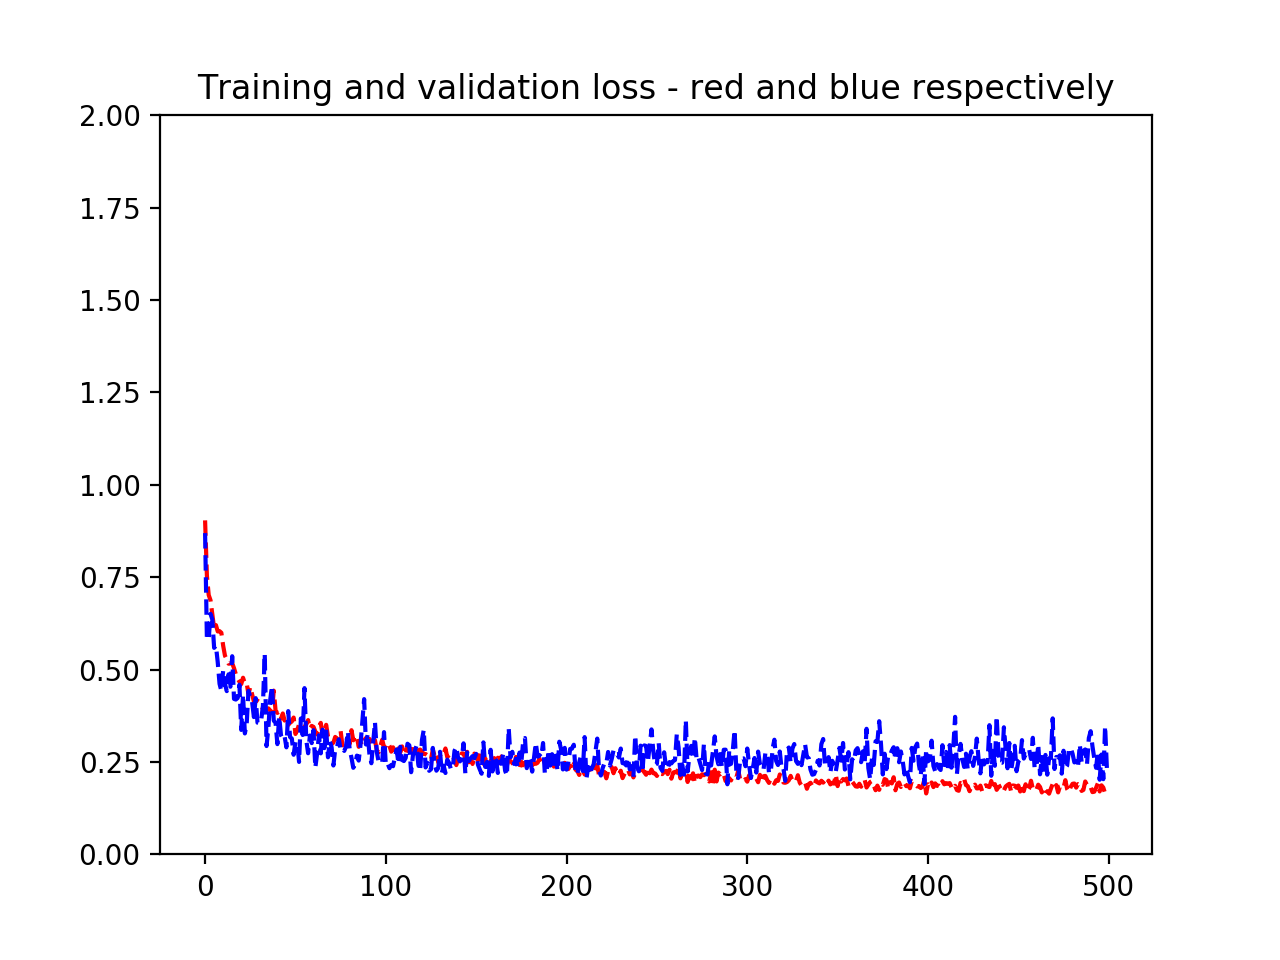

<IPython.core.display.Javascript object>


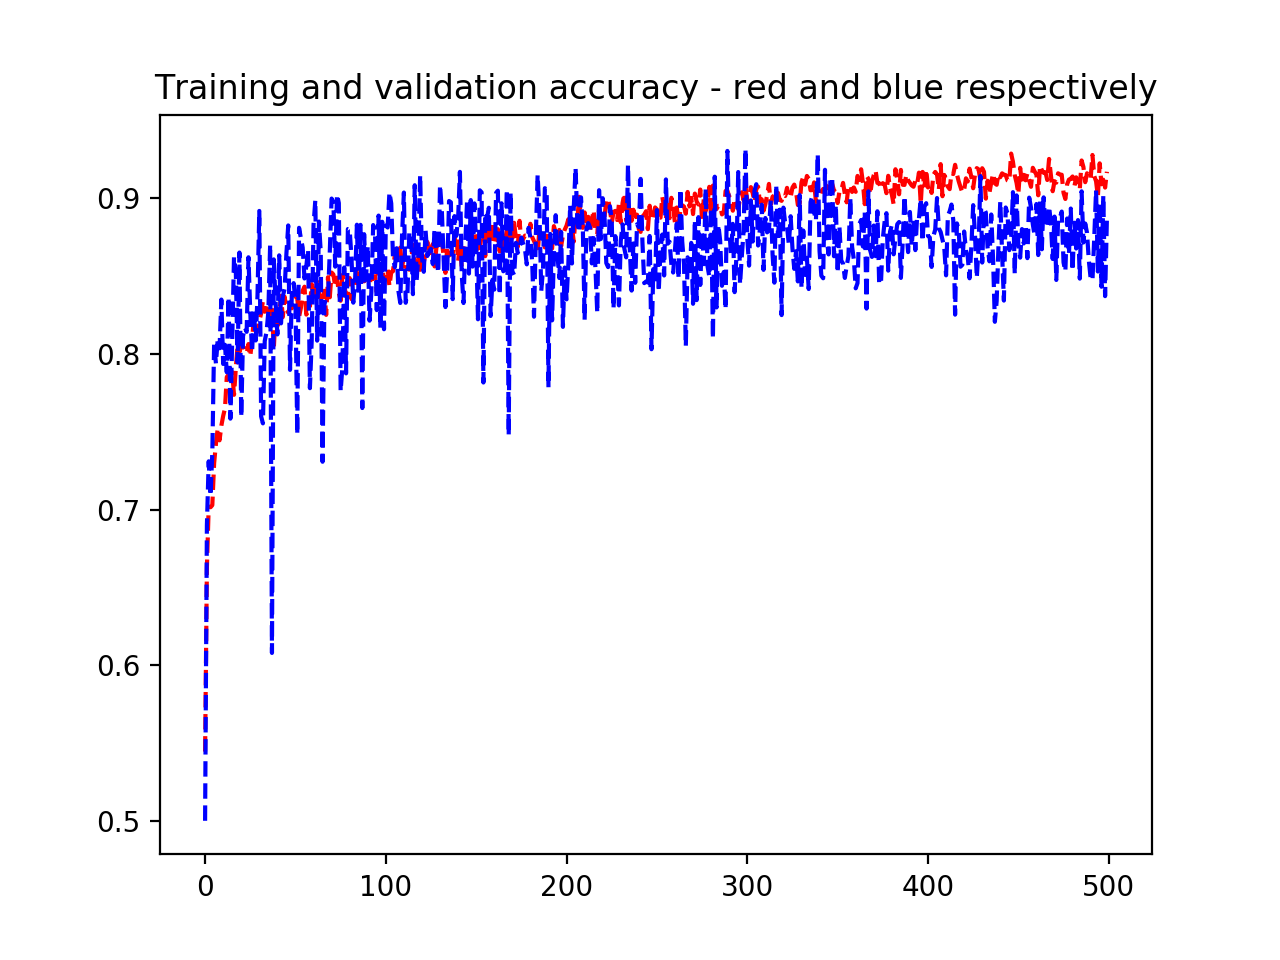

done


In [4]:
saved_dir = '../saved/IMPRS_hdf5_volume_AllDAPI_downsample/0701_155231'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [94]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    all_softmax = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            m = torch.nn.Softmax(dim=0)
            for row in output.cpu():
                sm = m(row)
                all_softmax.append(sm.data.numpy())
            print("prediction percentages")
            if i < 10:
                m = torch.nn.Softmax(dim=0)
                
                print(all_softmax[i])
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    outputcsv = True
    if outputcsv:
        ids = data_loader.ids
        softmax = pd.DataFrame(all_softmax)
        ids = ids[:,1].reshape(ids.shape[0], 1)
        print(ids.shape)
        print(softmax.shape)
        frames = [ids, softmax]
        output_data= np.concatenate(frames, axis=1)
        print(output_data.shape)
        output_df = pd.DataFrame(output_data)
        output_df.to_csv('overlaycsv.csv', index=False,  header=False)
        
        
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [95]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True



  0%|          | 0/14 [00:00<?, ?it/s]

Tesla K80



 14%|█▍        | 2/14 [00:00<00:01,  6.27it/s]

prediction percentages
[0.9948349  0.00516512]
1
prediction percentages
[0.0065346  0.99346536]
1



 29%|██▊       | 4/14 [00:00<00:01,  7.21it/s]

prediction percentages
[0.00946809 0.9905319 ]
1
prediction percentages
[0.00629968 0.99370027]
1
prediction percentages
[0.9028652  0.09713478]
1



 57%|█████▋    | 8/14 [00:00<00:00,  8.85it/s]

prediction percentages
[0.04925813 0.9507418 ]
1
prediction percentages
[0.01461237 0.9853876 ]
1
prediction percentages
[0.00954165 0.99045837]
1



 71%|███████▏  | 10/14 [00:00<00:00,  9.85it/s]

prediction percentages
[0.77267116 0.22732879]
1
prediction percentages
[0.01375532 0.98624474]
1
prediction percentages



100%|██████████| 14/14 [00:01<00:00, 11.19it/s]

prediction percentages
prediction percentages
prediction percentages
(850, 1)
(850, 2)
(850, 3)
num test images = 850
loss = 0.6339
my_metric = 0.8400
f1 = 0.9053
balanced_accuracy = 0.8421
precision = 0.9888
recall = 0.8400
My_metric is accuracy
Confusion matrix, without normalization
[[375  41]
 [ 95 339]]


<IPython.core.display.Javascript object>


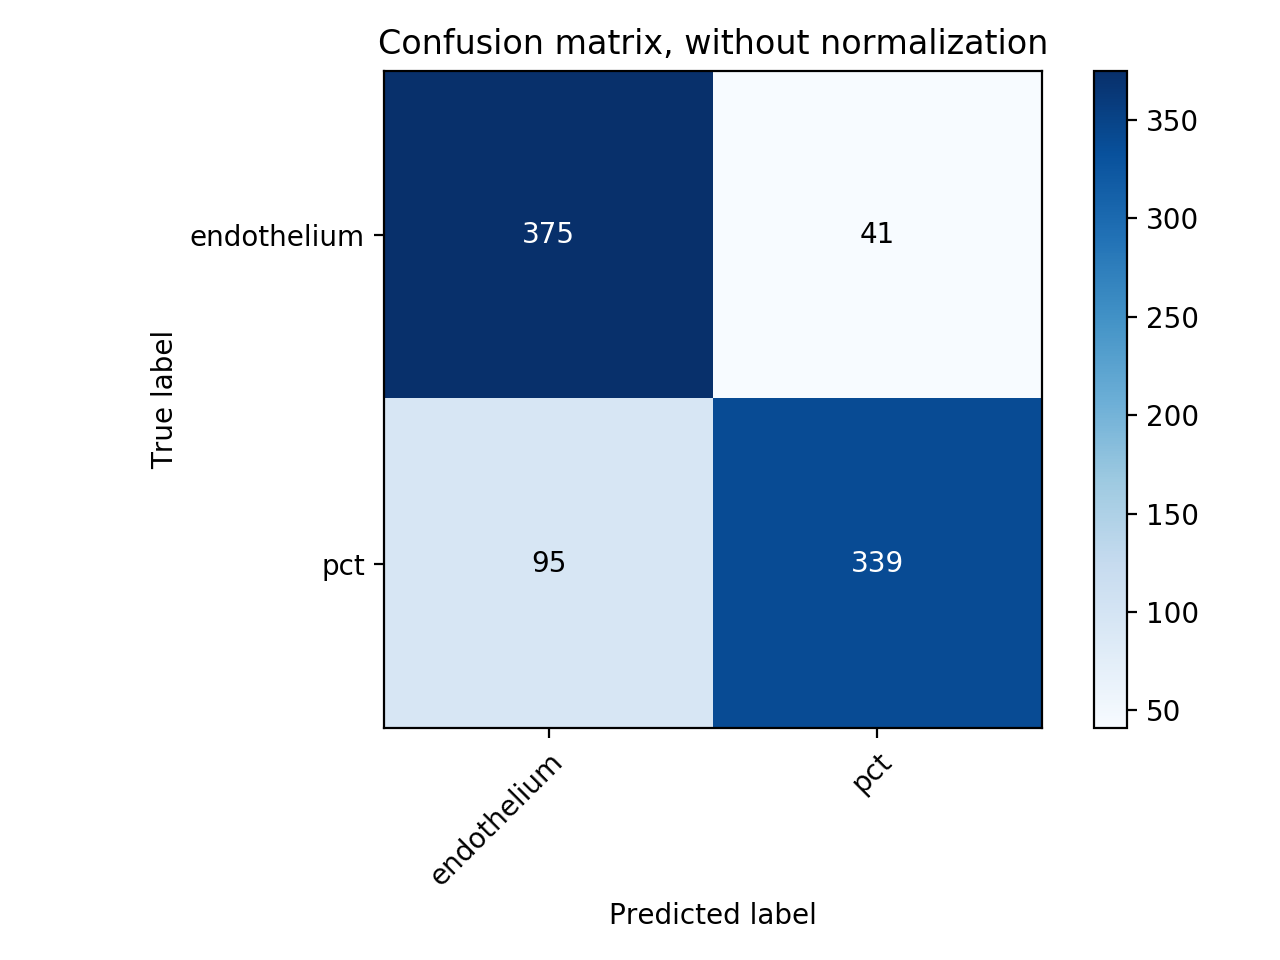

In [96]:
#Test
main2(config, resume)
